# Convert Kinetics Library to Training Reactions Script

Specify the kinetics library name below and run the script.  It automatically overwrites the training reactions files it needs to.  Then you should commit those files.

This script only trains safely.  In other words, if a single match from an RMG family is found, a training reaction is created.  Sometimes, there are no matches from RMG reaction families, or multiple matches.  This indicates an error that requires manual fixing, and a printout is given in the script.

In [1]:
# Set libraries to load reactions from; set to None to load all libraries
libraries = ['PFAS_1atm_V1p0']

# Set families to add training reactions to; either 'default' or a list, e.g. ['R_Addition_MultipleBond']
families = ['default', 'halogens']

# Specify whether to plot kinetics comparisons
compare_kinetics = True

# Specify whether to print library reactions which don't fit in the specified families
# This can result in a lot of unnecessary output if only using a few families
show_all = True

# Specify whether to prioritize aromatic resonance structures to reduce cases of multiple matches
filter_aromatic = True

# Specify whether to use verbose comments when averaging tree
verbose_comments = True

In [2]:
from rmgpy import settings
from rmgpy.data.rmg import RMGDatabase
from kinetics_library_to_training_tools_modified import *
from base64 import b64encode
from IPython.display import display, HTML


In [3]:
thermolibs = [
'C1_C2_Fluorine',
'Fluorine',
'primaryThermoLibrary',
'FFCM1(-)',
'halogens',
'CHOF_G4',
'CHOCl_G4',
'CHOBr_G4',
'CHOFCl_G4',
'CHOFBr_G4',
'CHOFClBr_G4',
'DFT_QCI_thermo',
'2-BTP_G4',
'thermo_DFT_CCSDTF12_BAC',
'SulfurHaynes'
]


## Step 1: Load RMG-database with specified libraries and families

In [4]:
database = RMGDatabase()
database.load(
    path = settings['database.directory'],
    thermo_libraries = thermolibs,  # Can add others if necessary
    kinetics_families = families,
    reaction_libraries = libraries,
    kinetics_depositories = ['training'],
)
# If we want accurate kinetics comparison, add existing training reactions and fill tree by averaging
if compare_kinetics:
    for family in database.kinetics.families.values():
        if not family.auto_generated:
            family.add_rules_from_training(thermo_database=database.thermo)
            family.fill_rules_by_averaging_up(verbose=verbose_comments)

## Step 2a: Generate library reactions from families to get proper labels


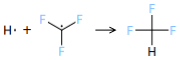
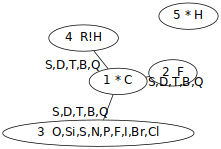
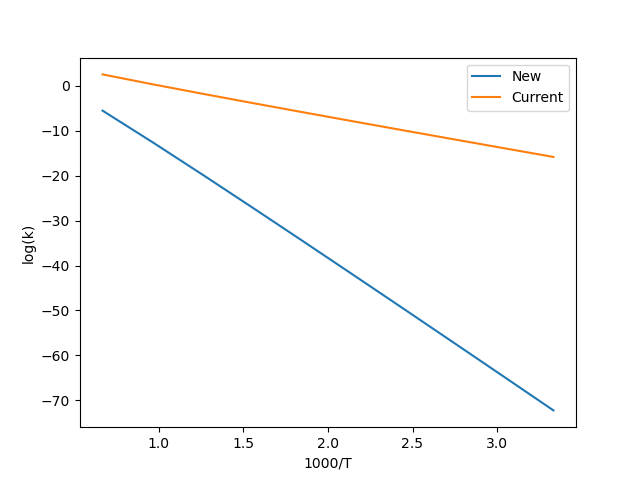


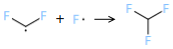
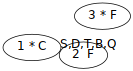
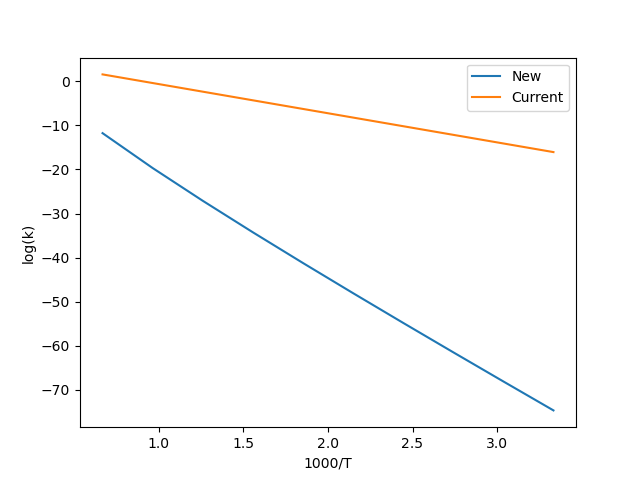


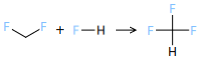
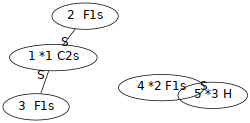
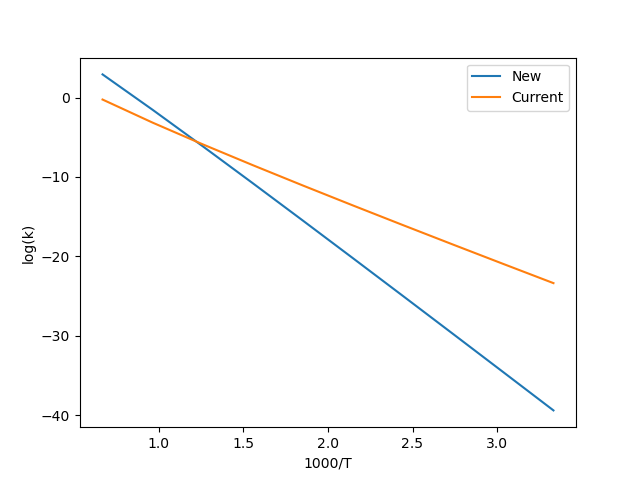


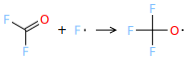
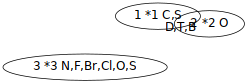
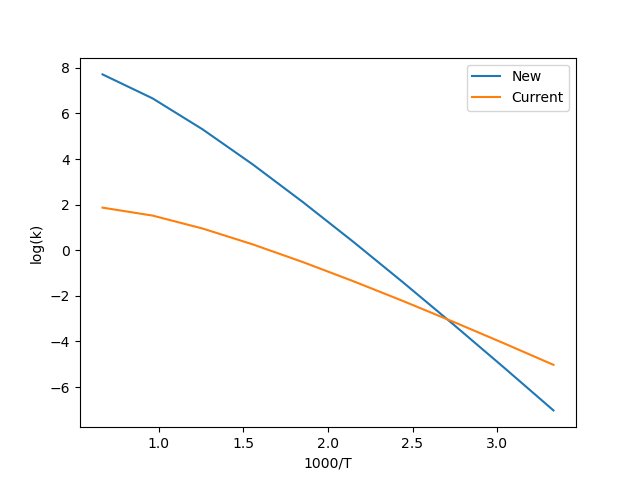


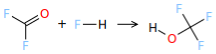
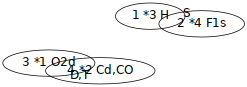
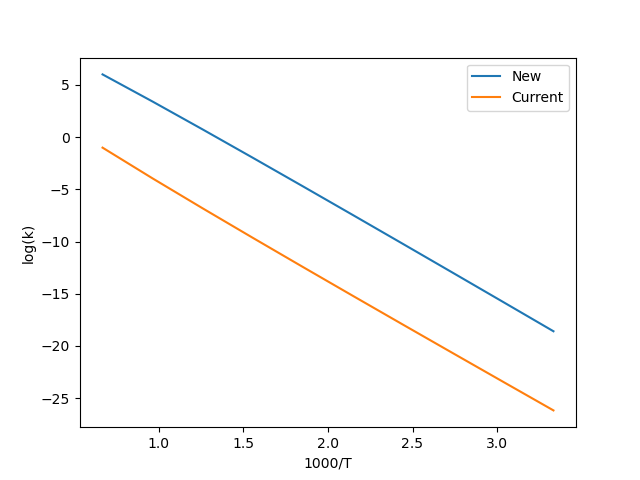


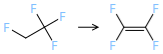
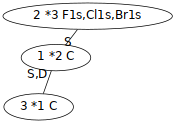
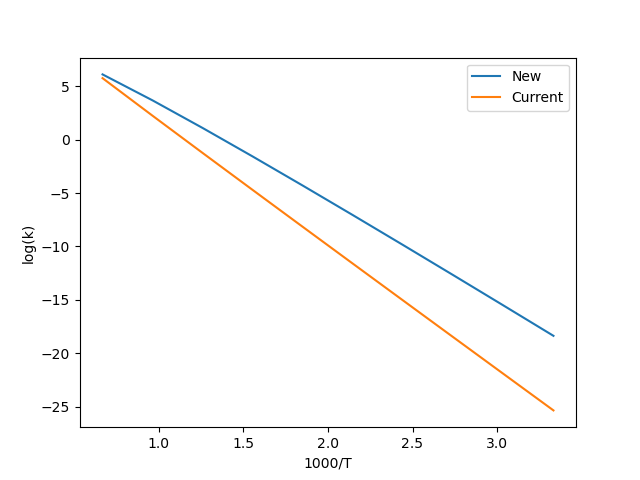


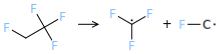


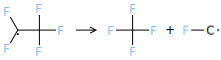


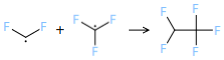
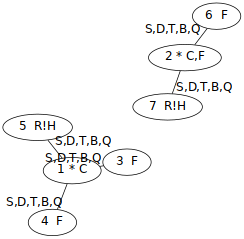
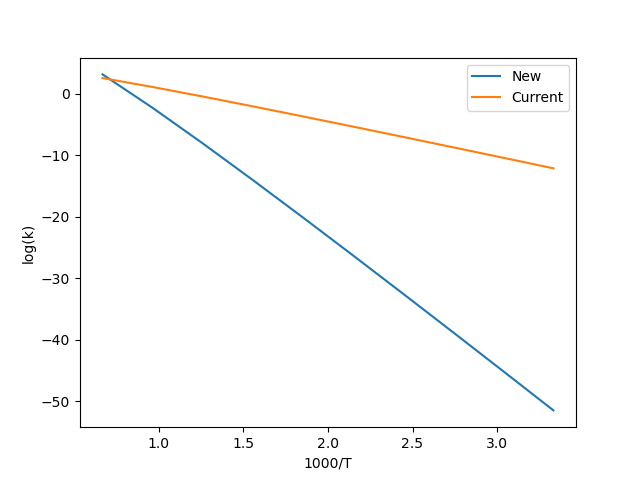


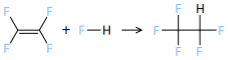
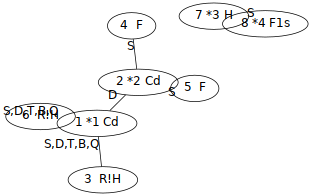
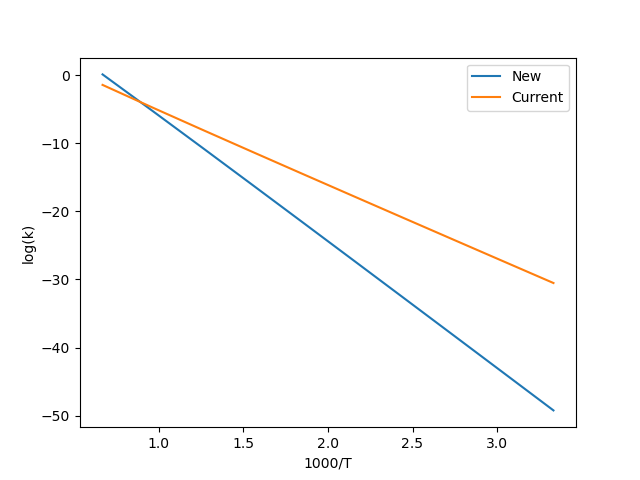


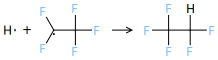
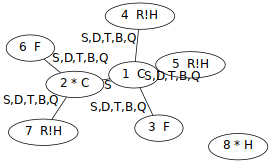
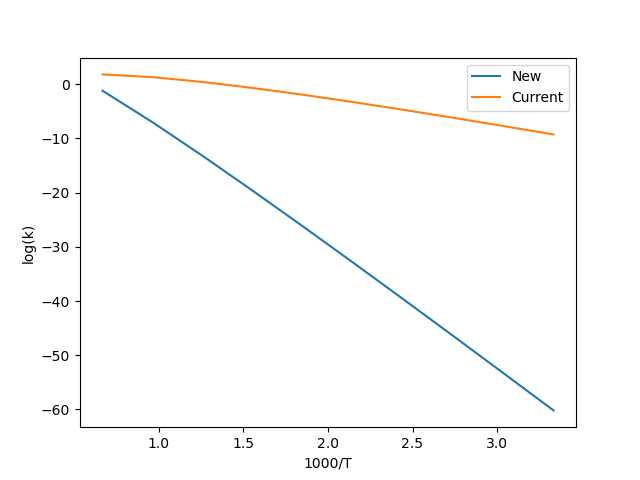


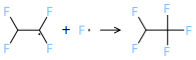
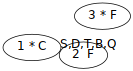
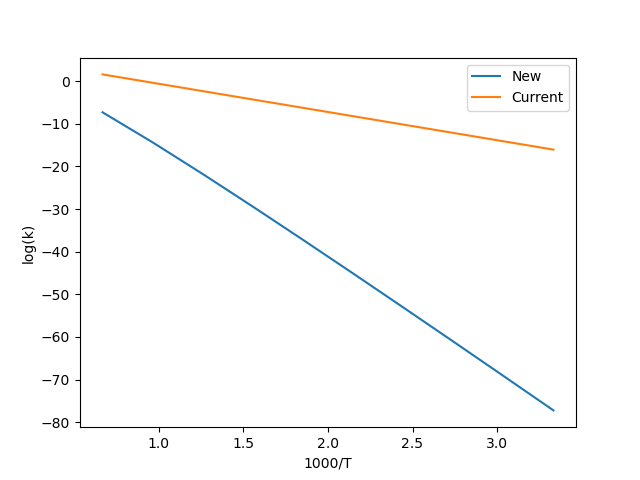


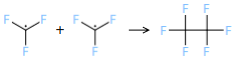
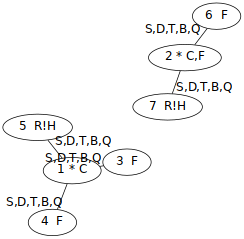
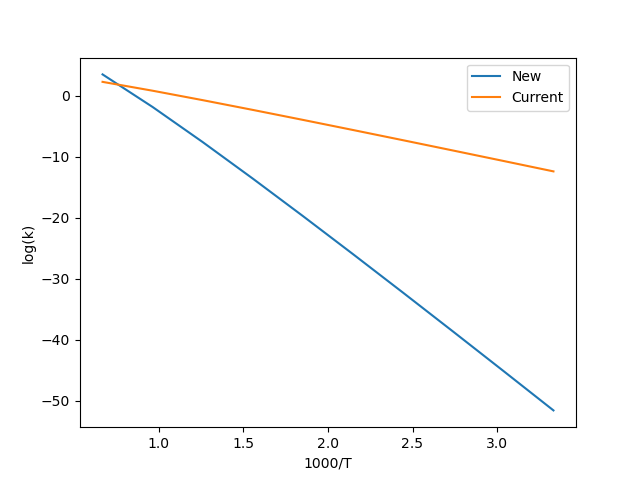


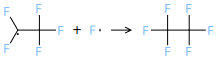
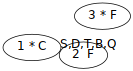
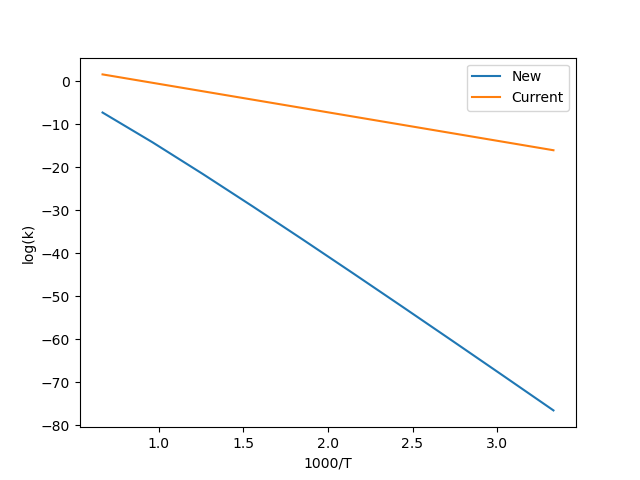


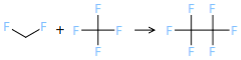
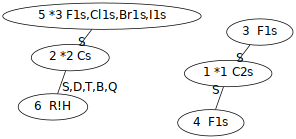
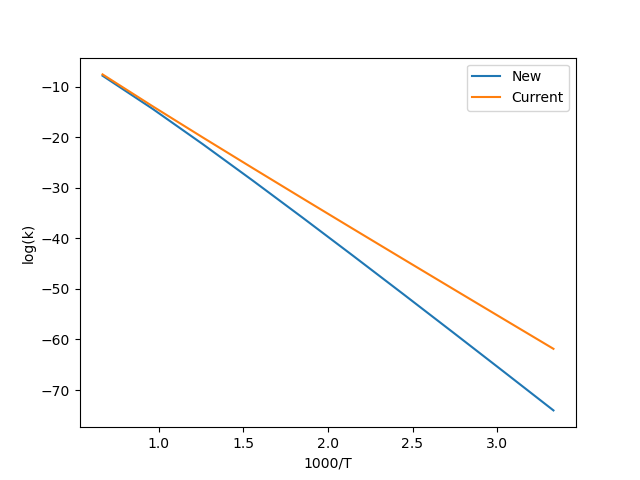


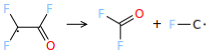


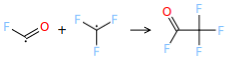
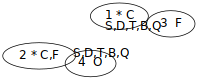
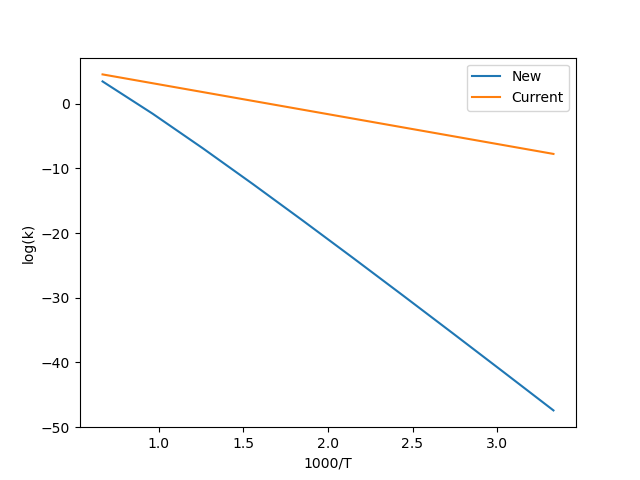


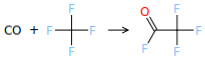
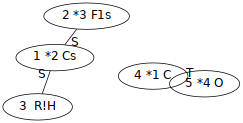
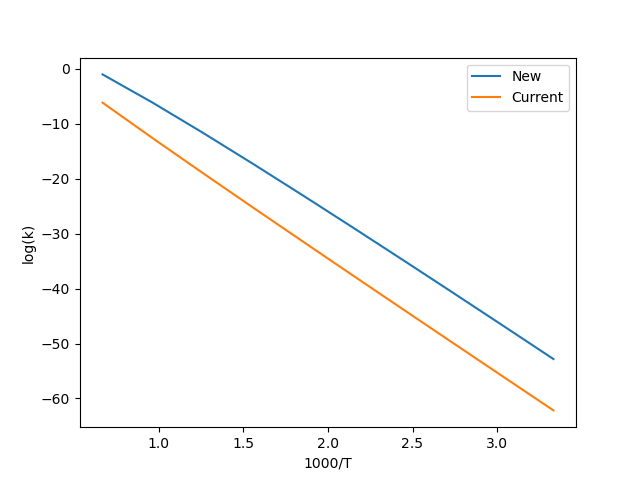


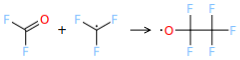
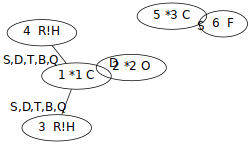
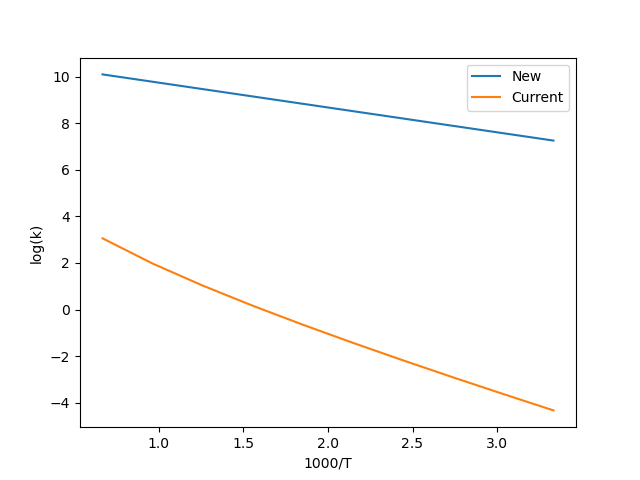


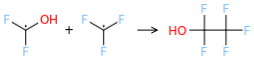
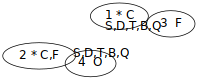
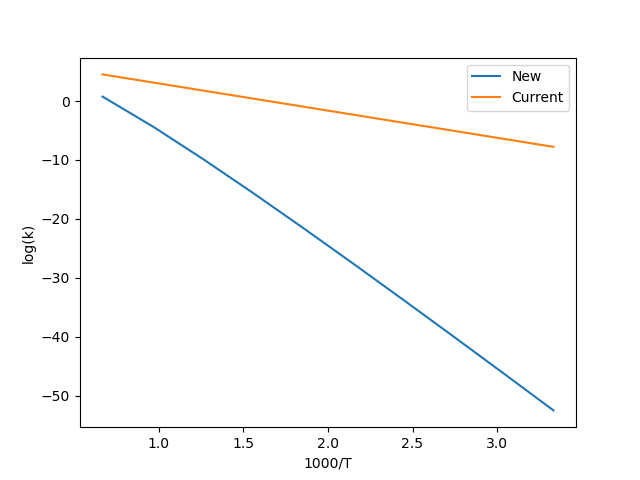


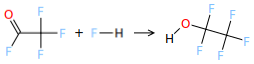
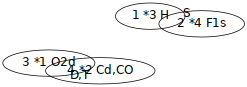
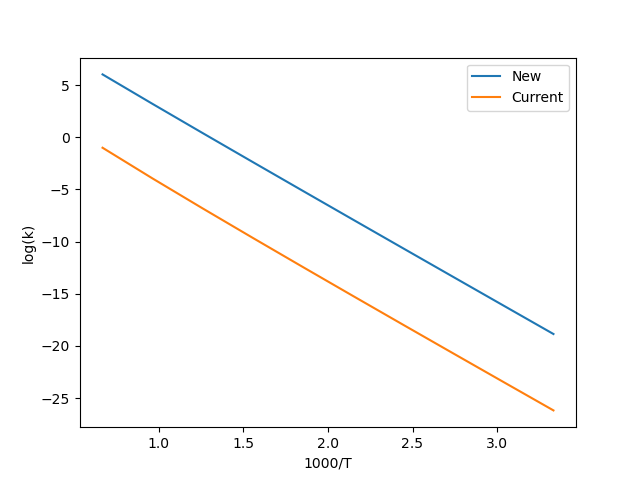


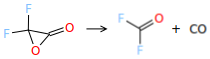


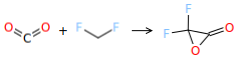
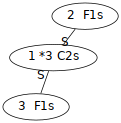
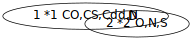
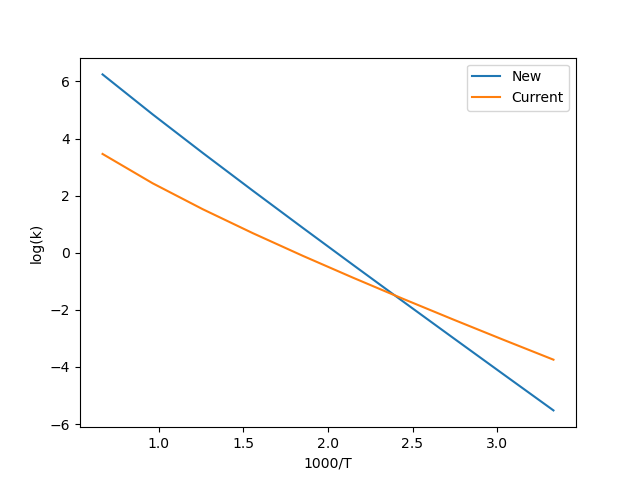


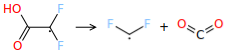


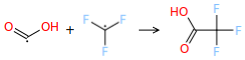
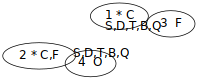
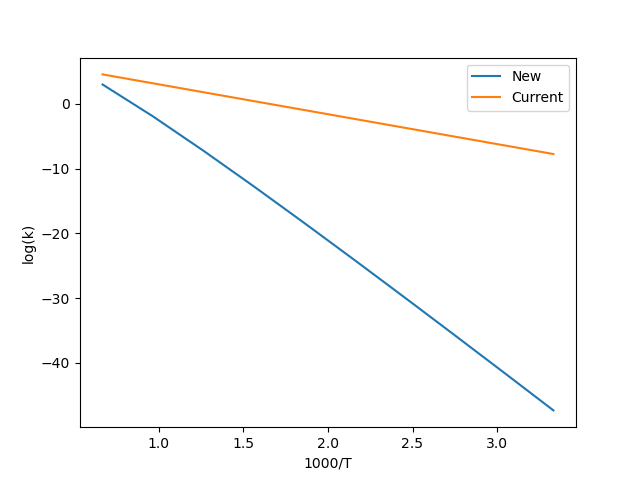


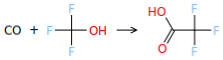
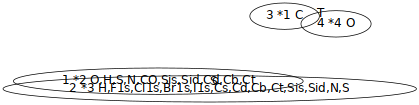
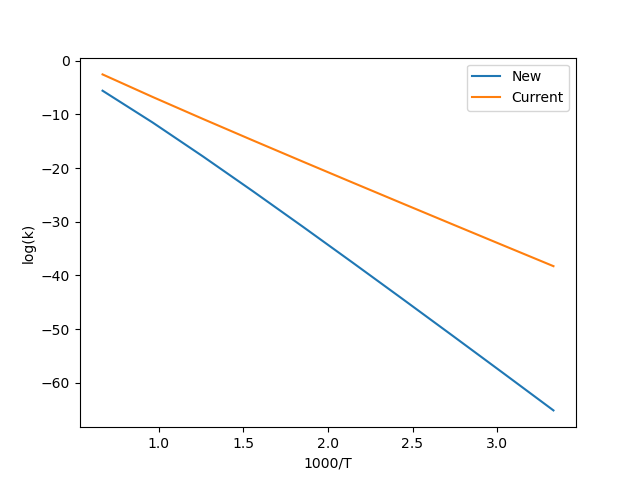


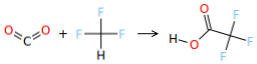
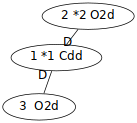
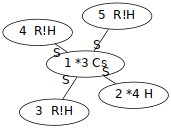
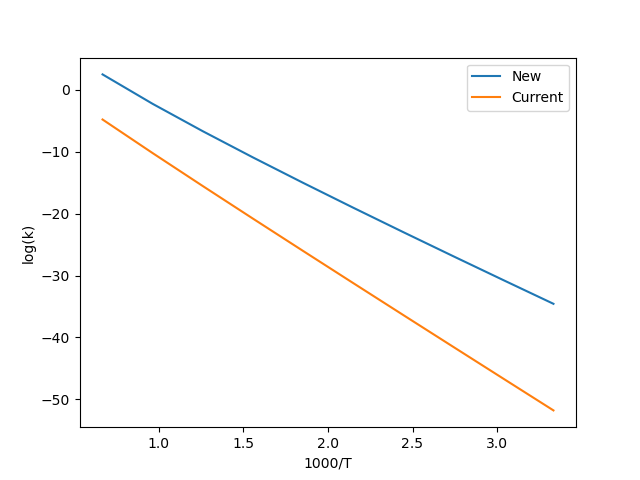


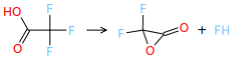


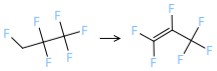
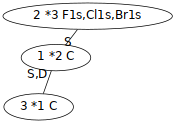
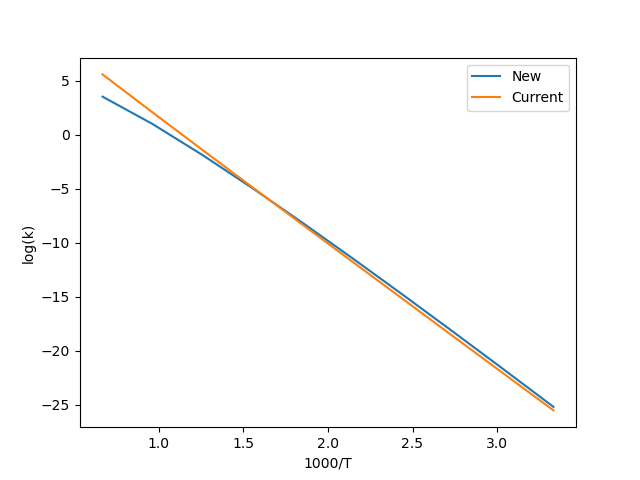


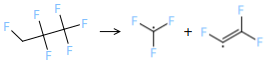


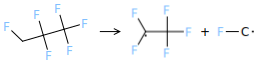


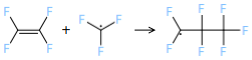
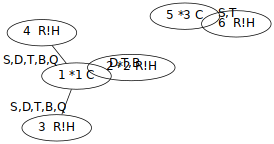
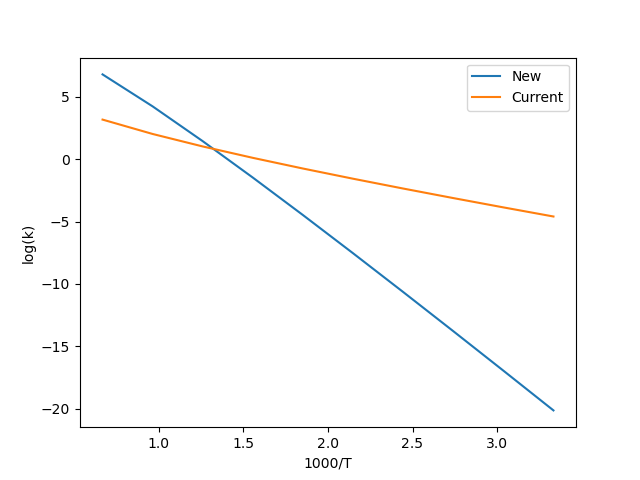


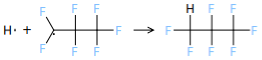
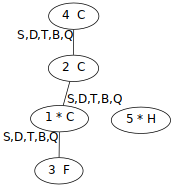
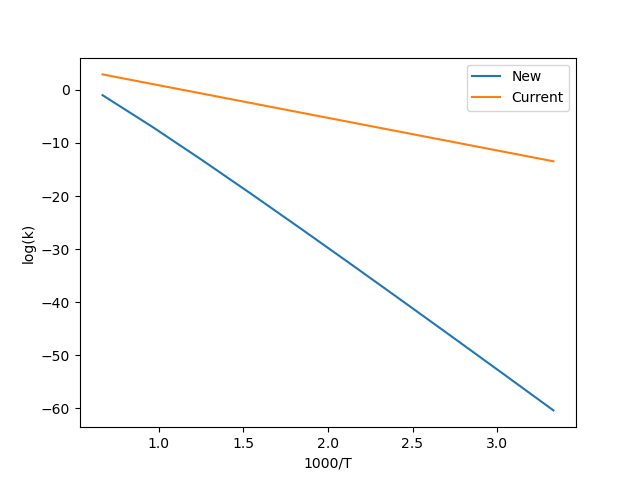


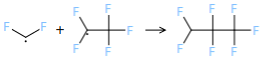
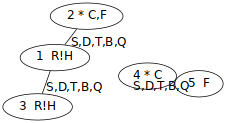
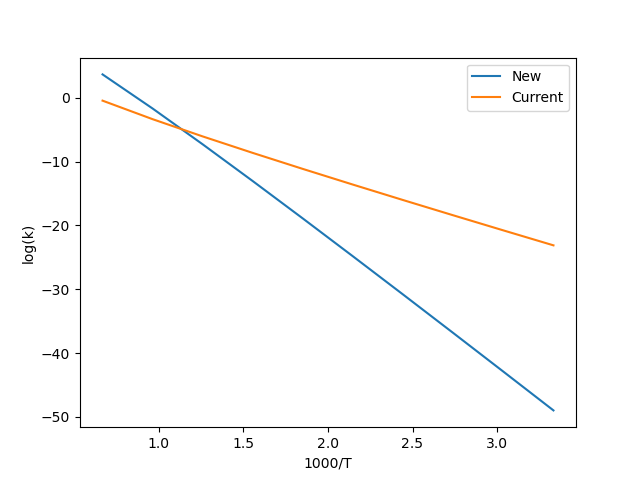


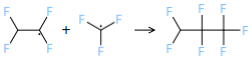
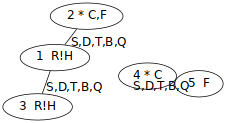
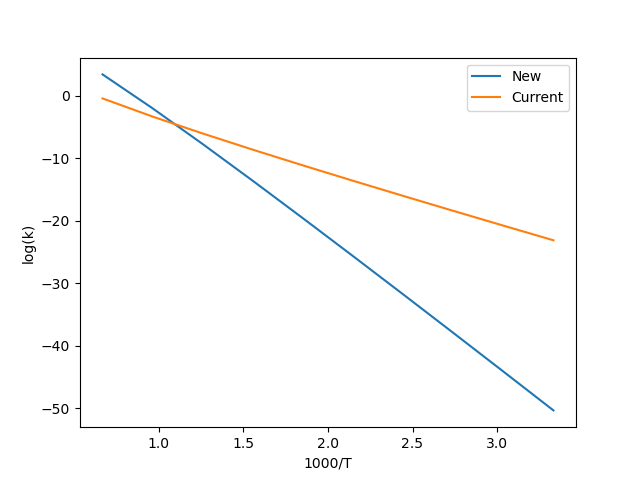


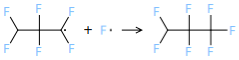
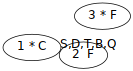
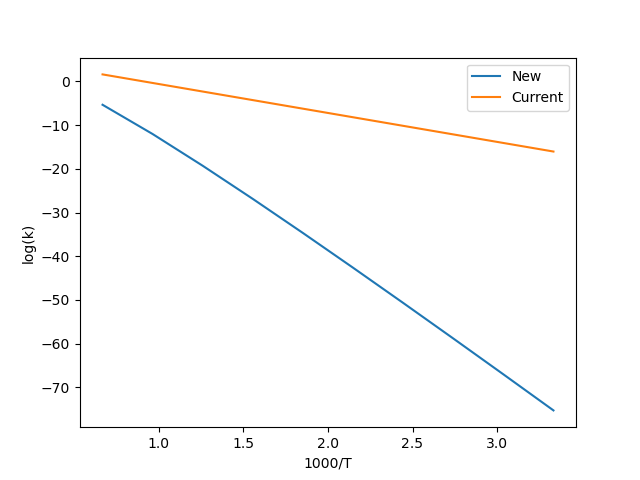


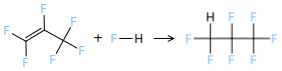
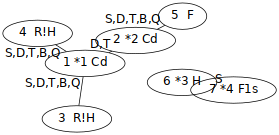
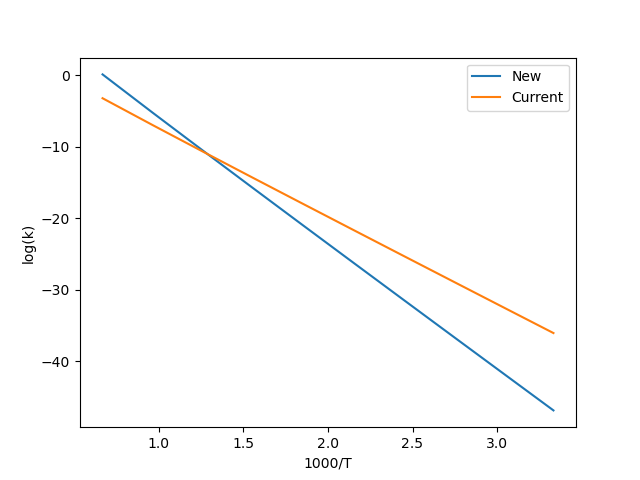


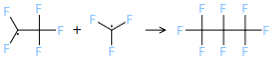
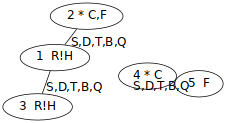
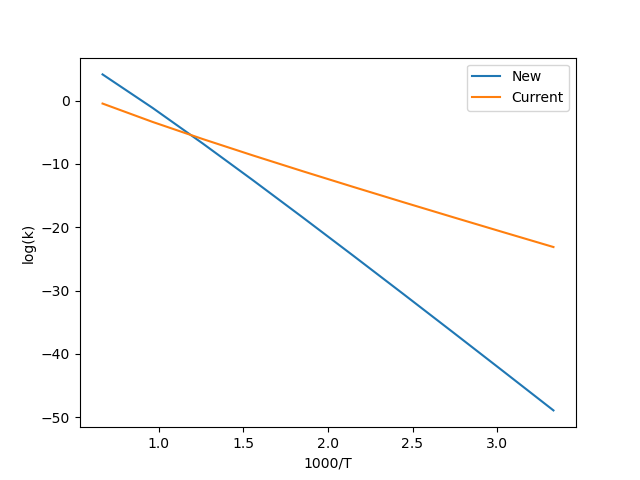


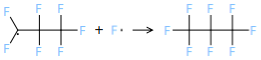
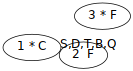
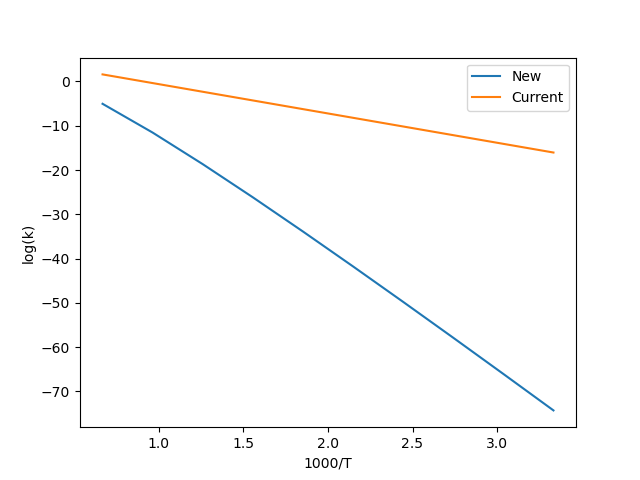


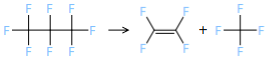


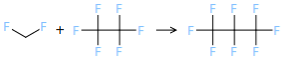
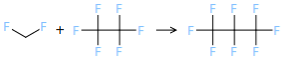
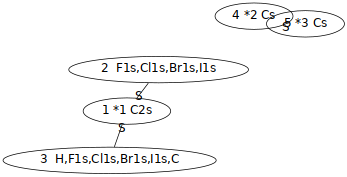
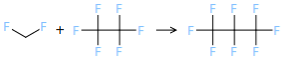
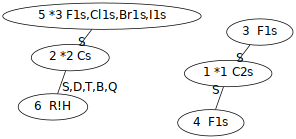
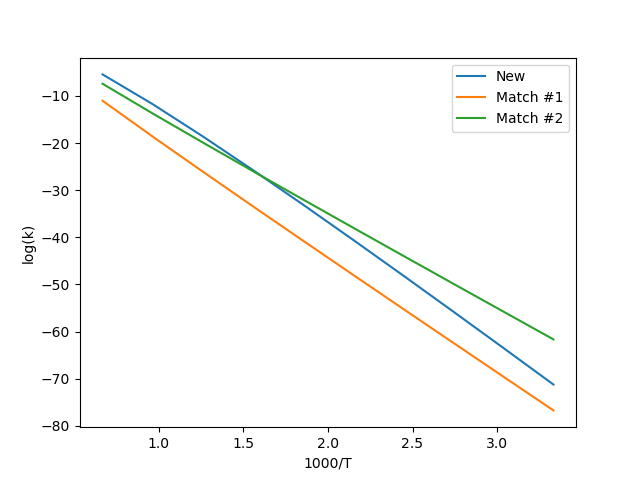


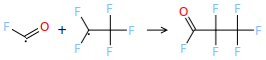
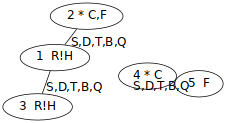
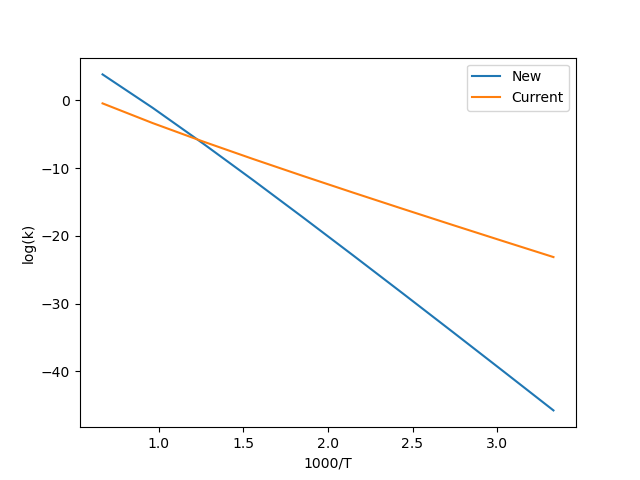


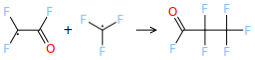
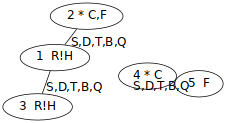
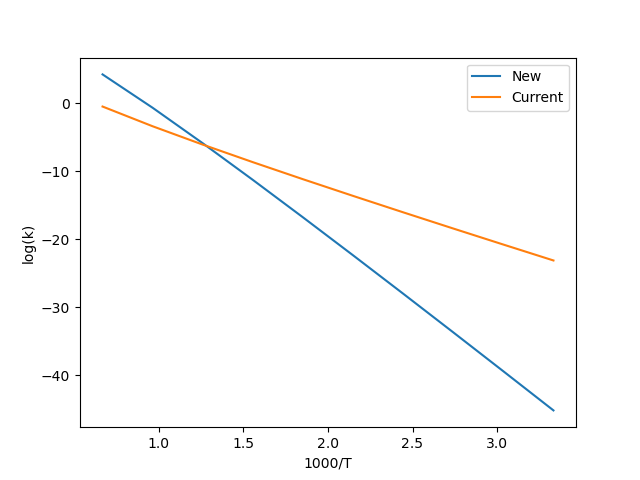


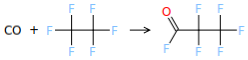
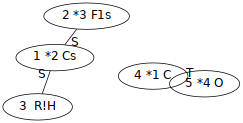
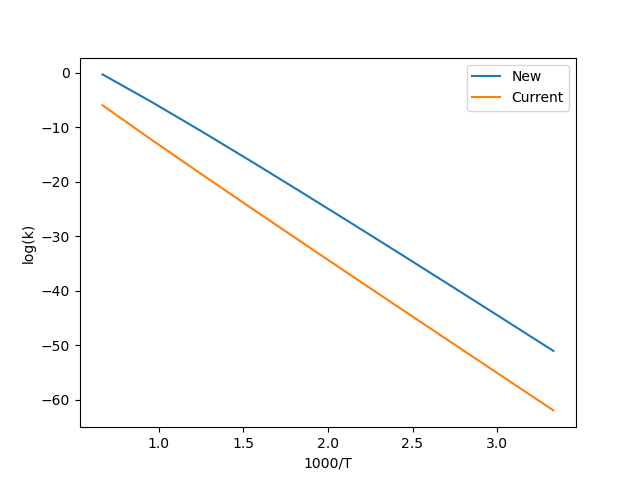


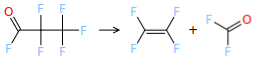


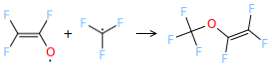
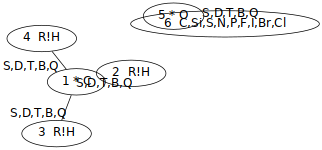
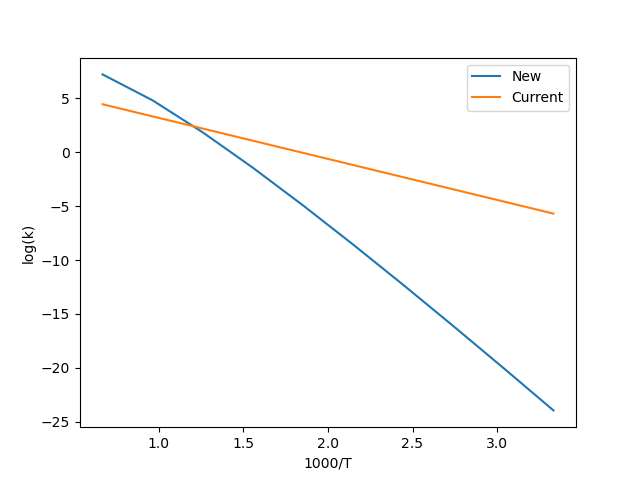


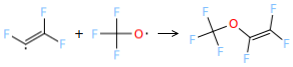
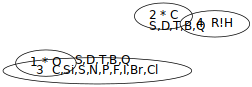
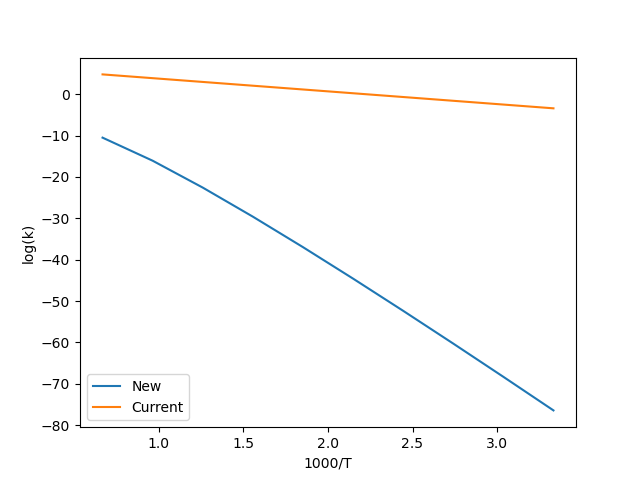


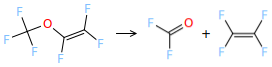


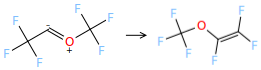


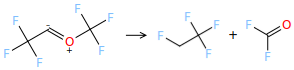


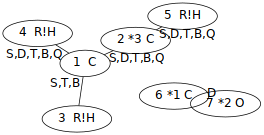
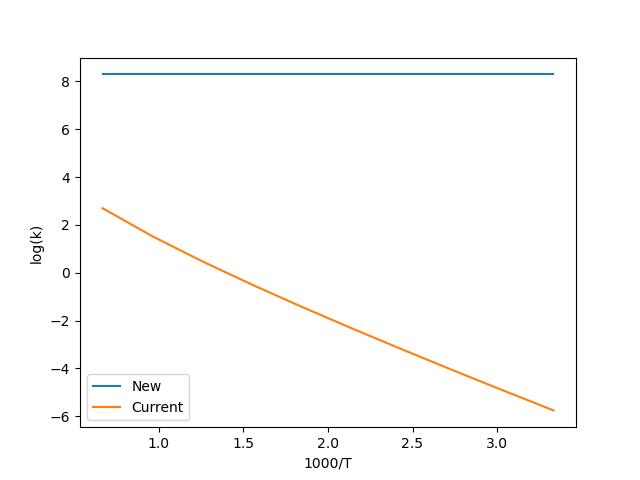


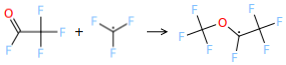
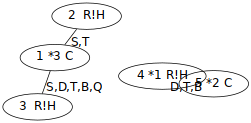
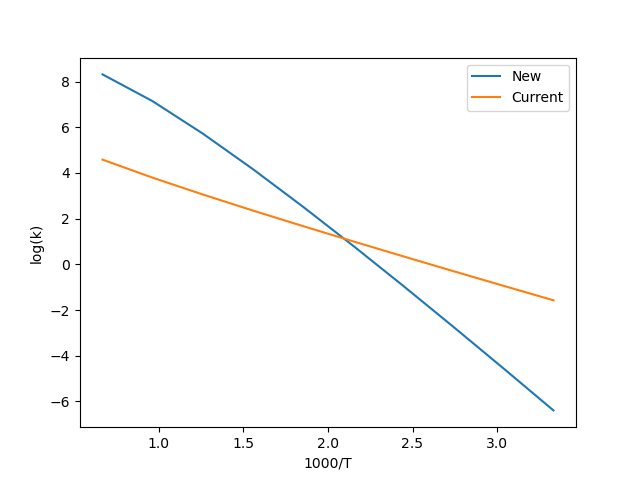


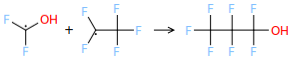
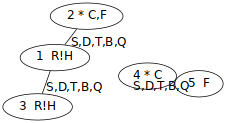
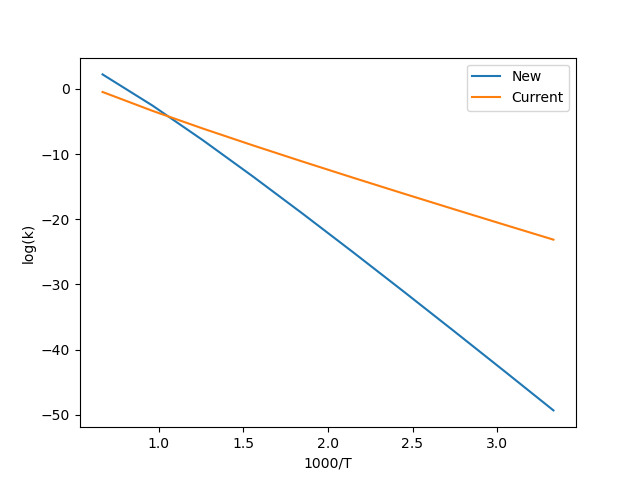


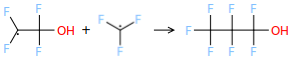
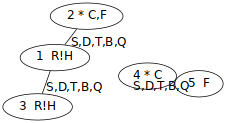
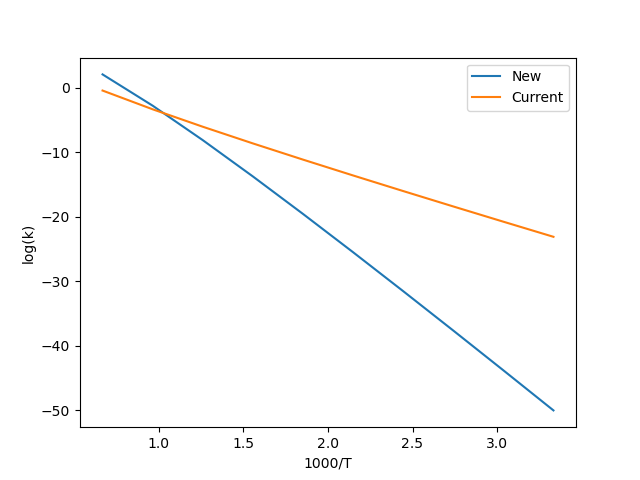


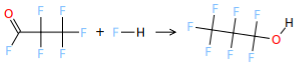
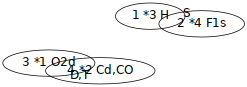
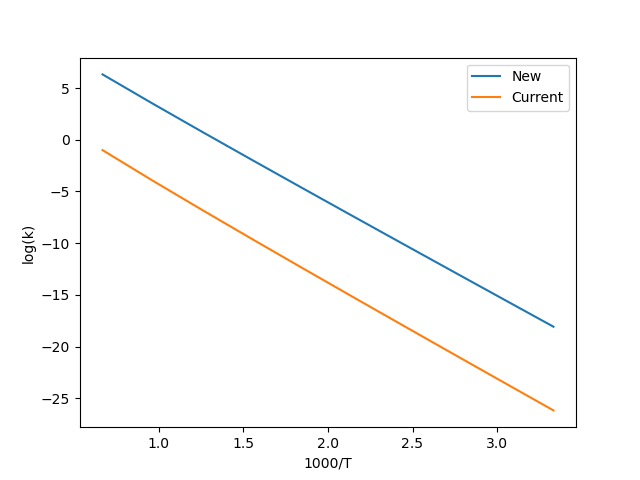


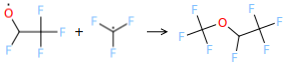
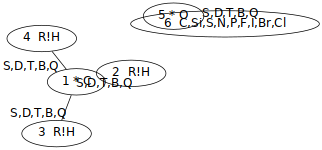
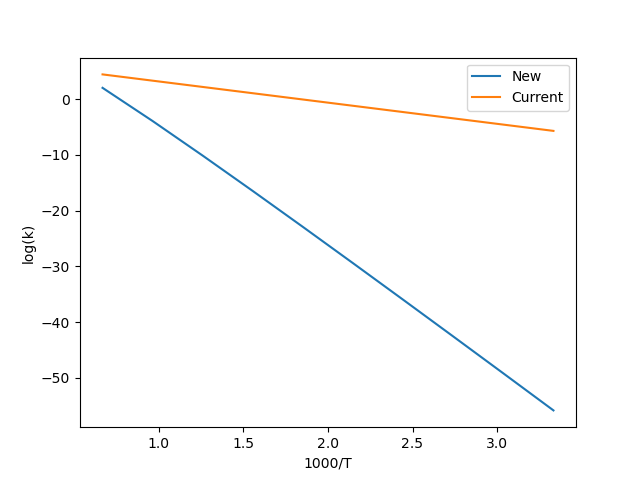


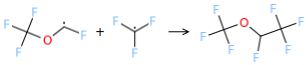
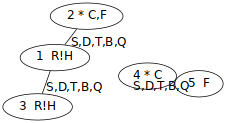
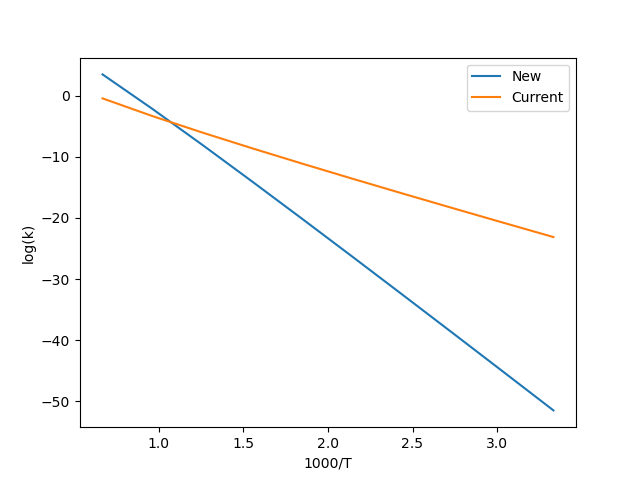


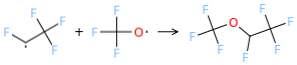
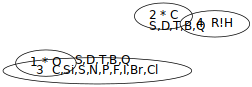
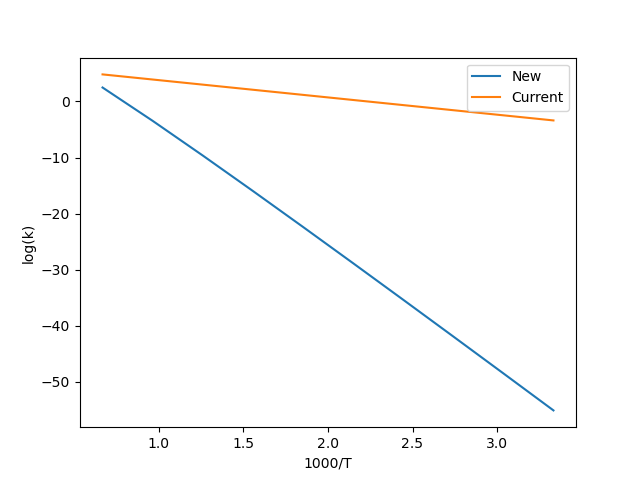


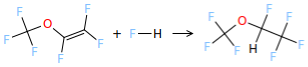
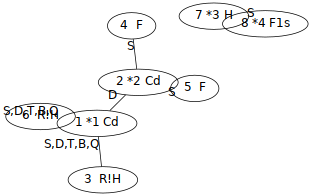
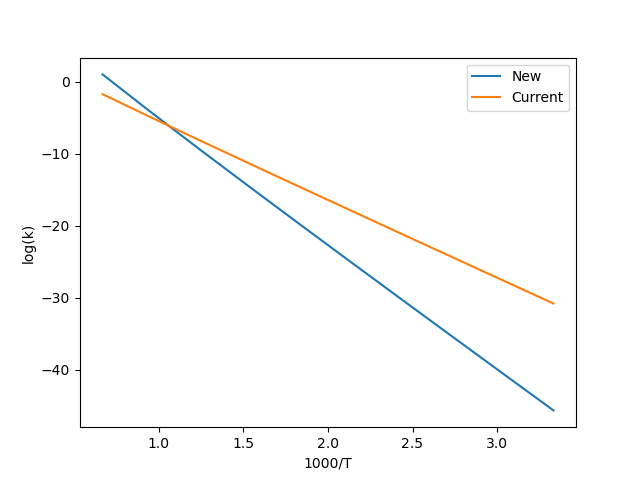


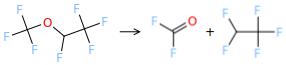


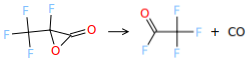


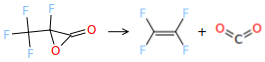


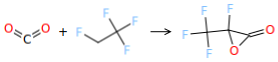
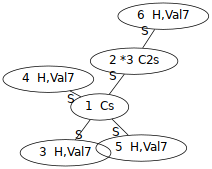
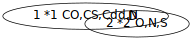
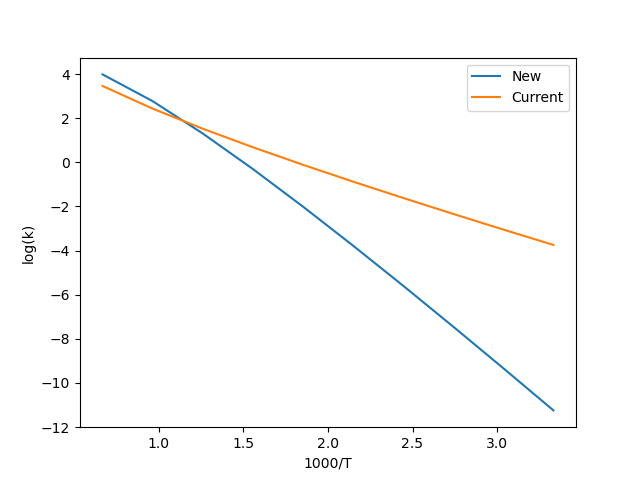


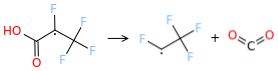


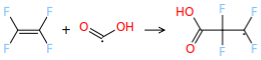
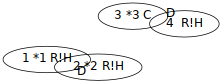
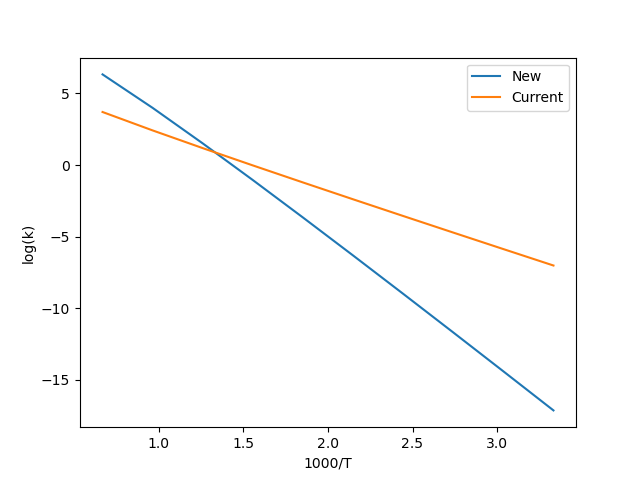


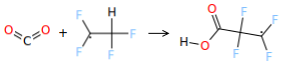
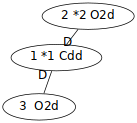
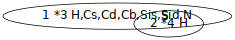
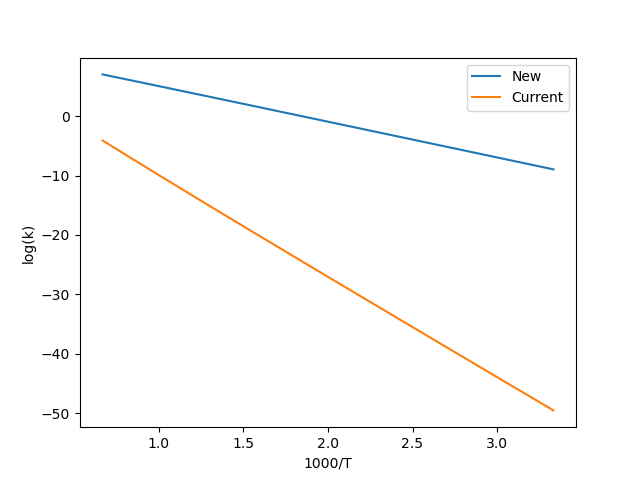


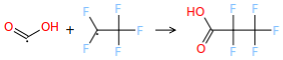
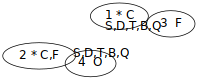
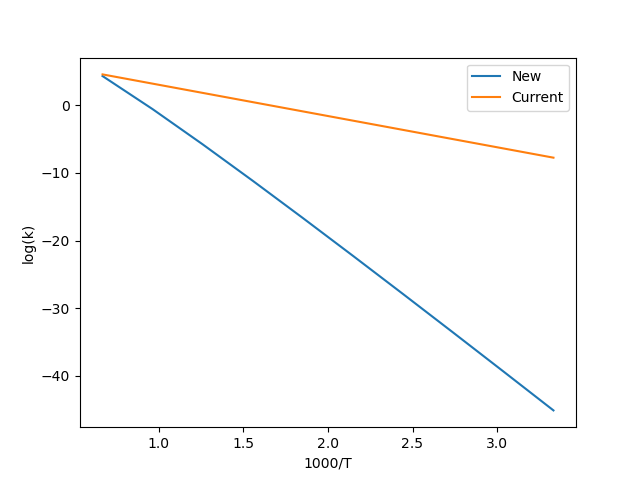


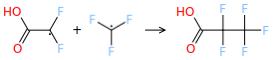
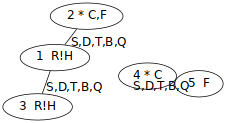
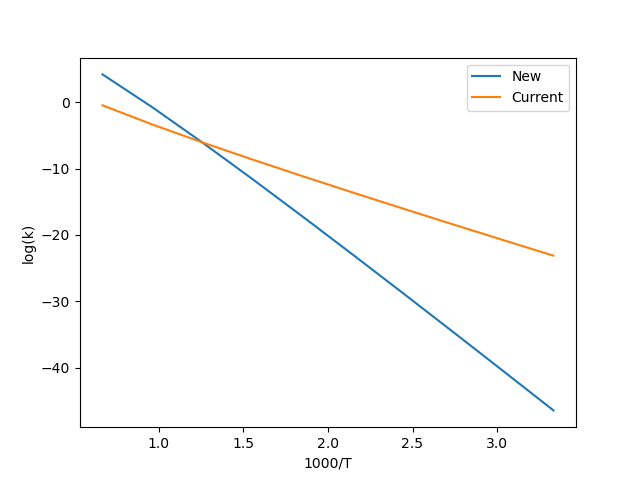


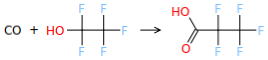
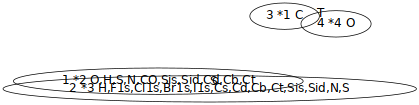
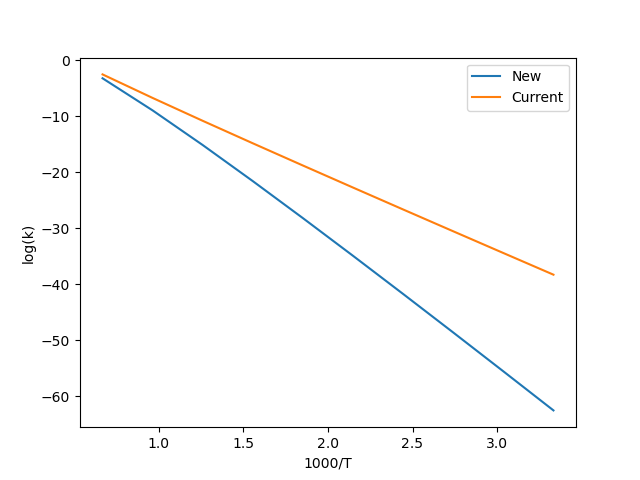


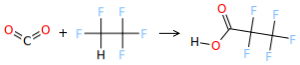
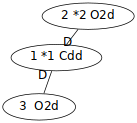
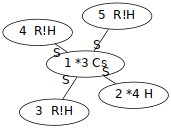
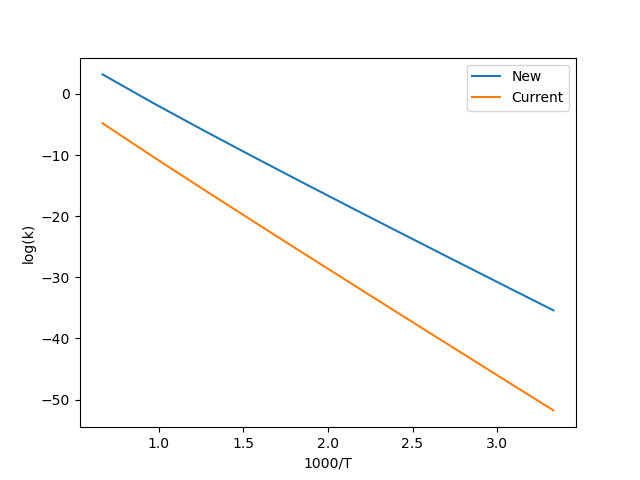


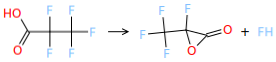


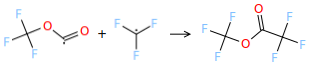
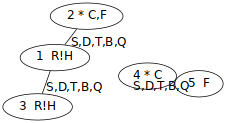
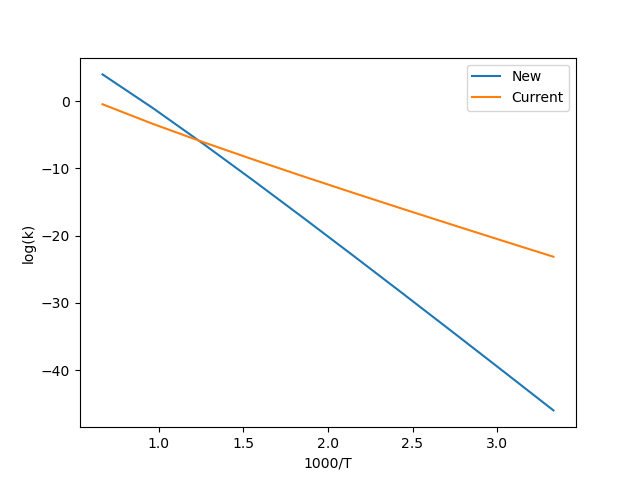


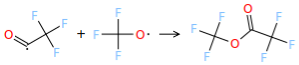
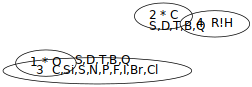
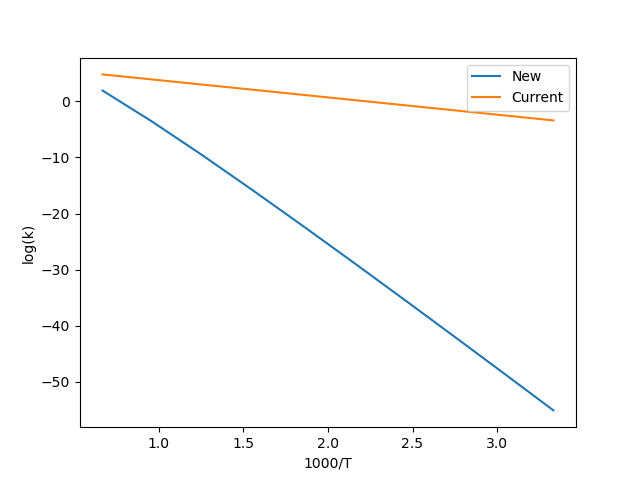


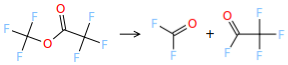


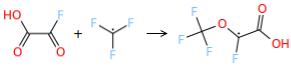
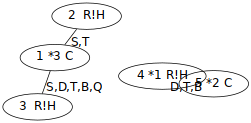
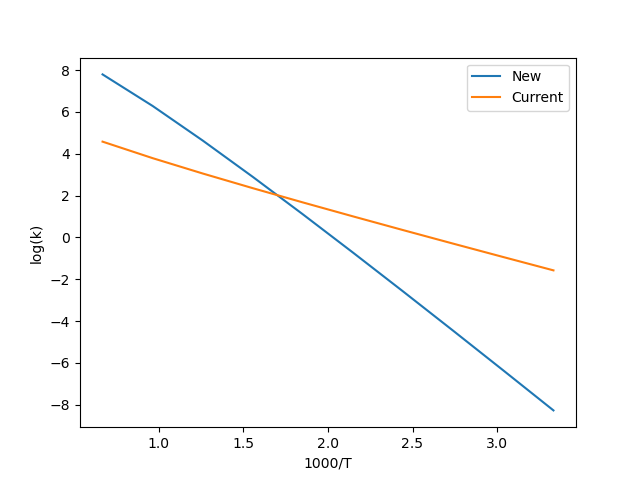


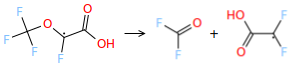


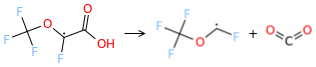


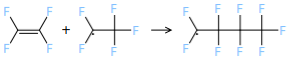
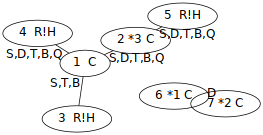
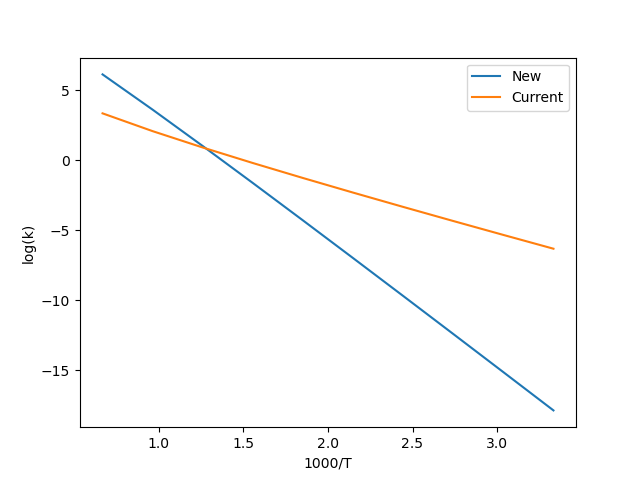


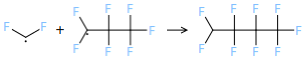
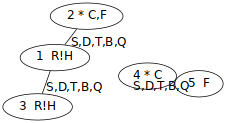
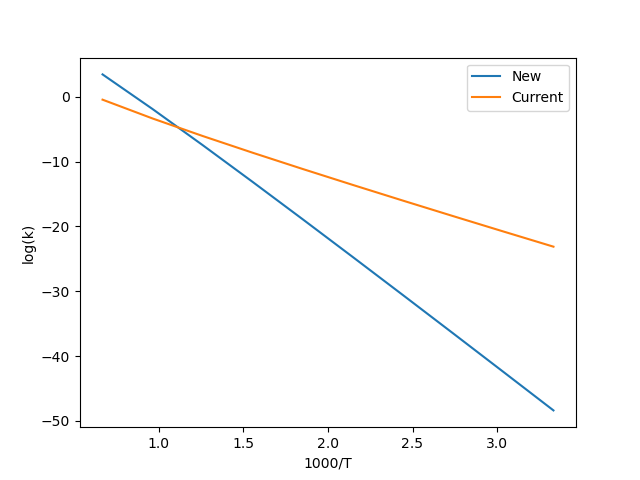


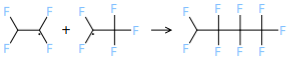
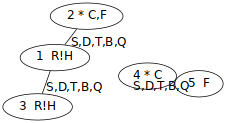
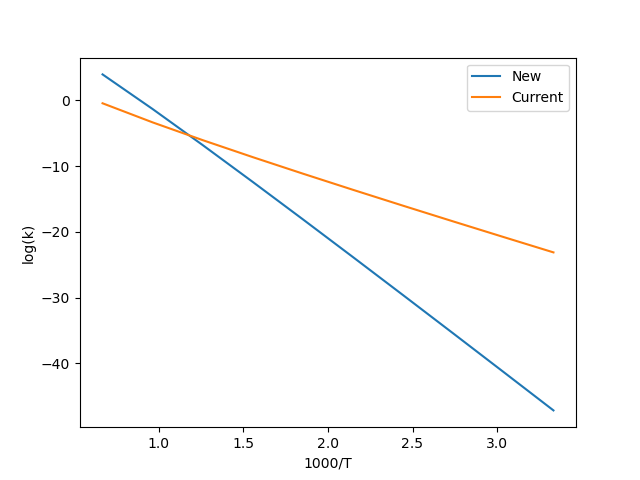


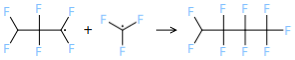
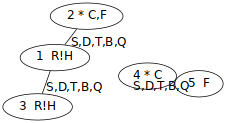
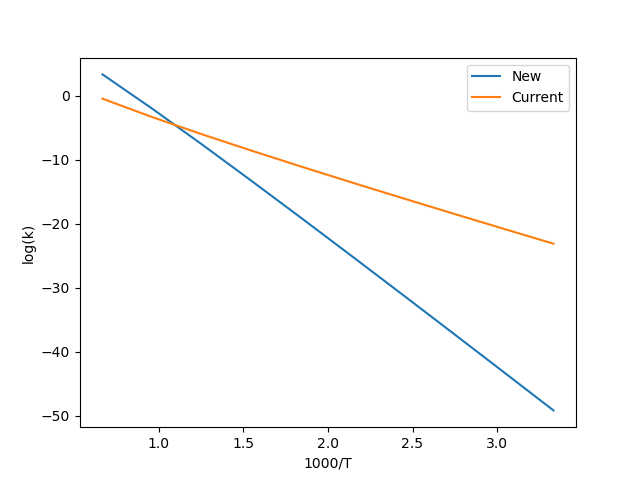


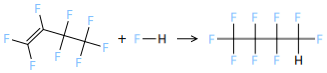
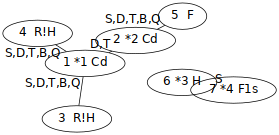
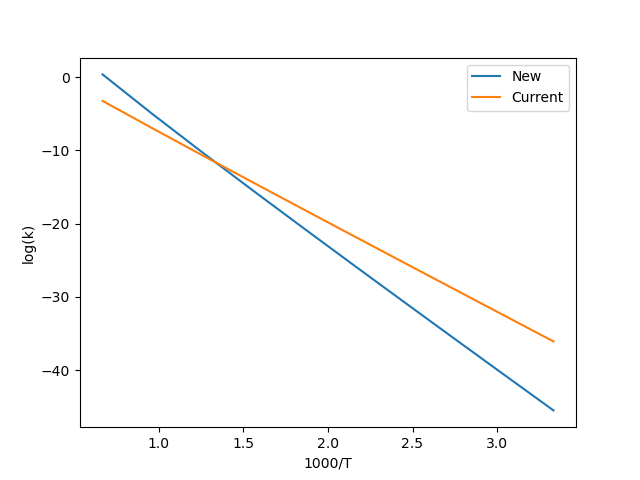


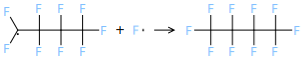
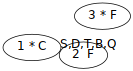
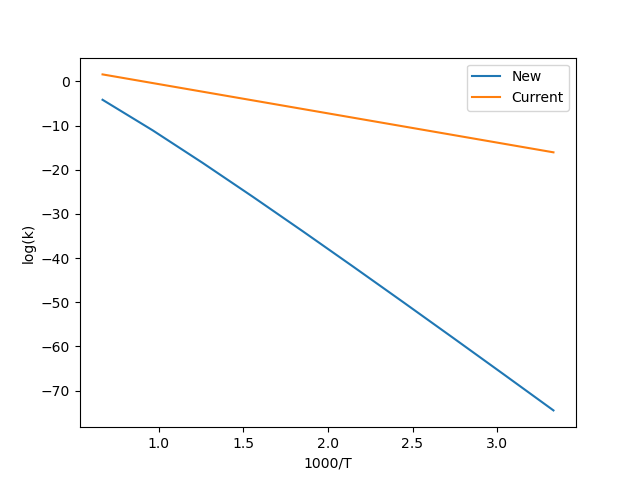


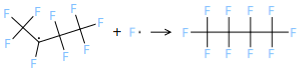
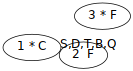
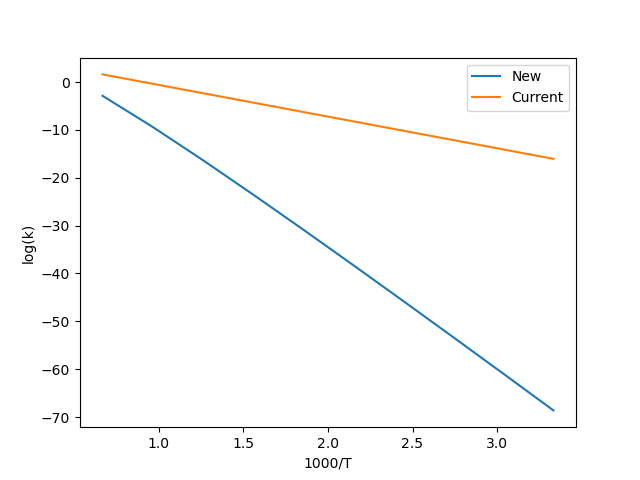


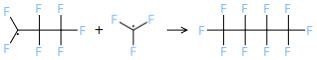
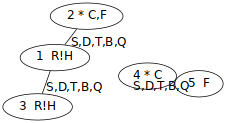
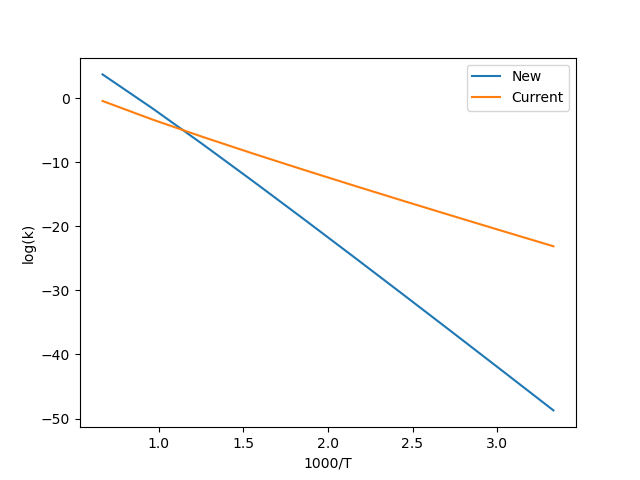


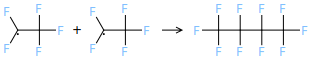
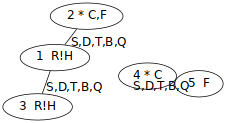
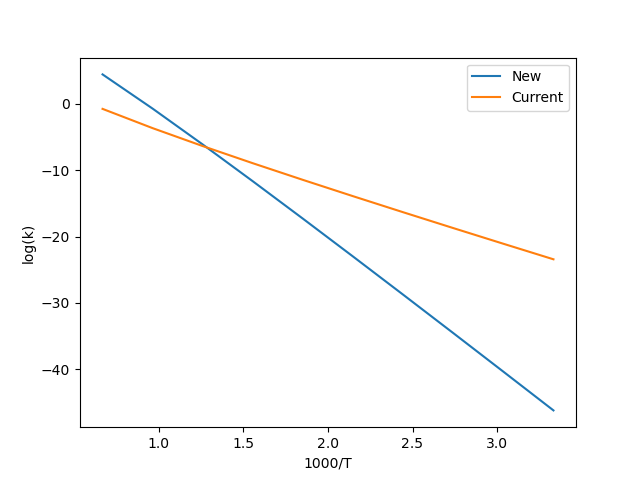


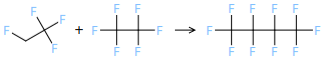
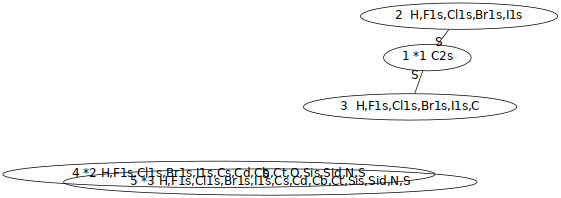
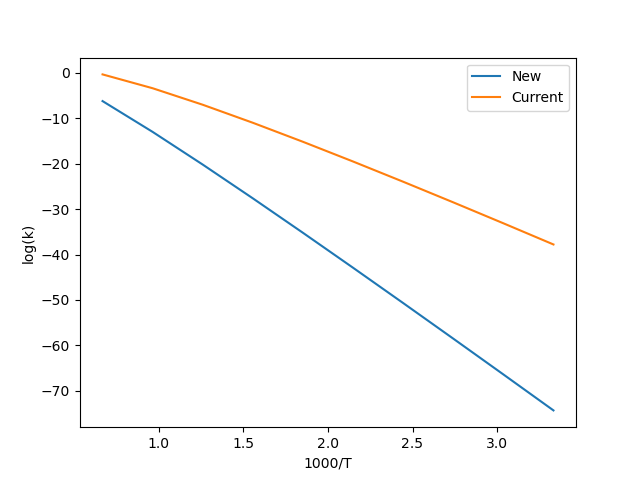


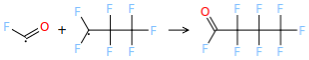
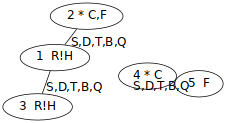
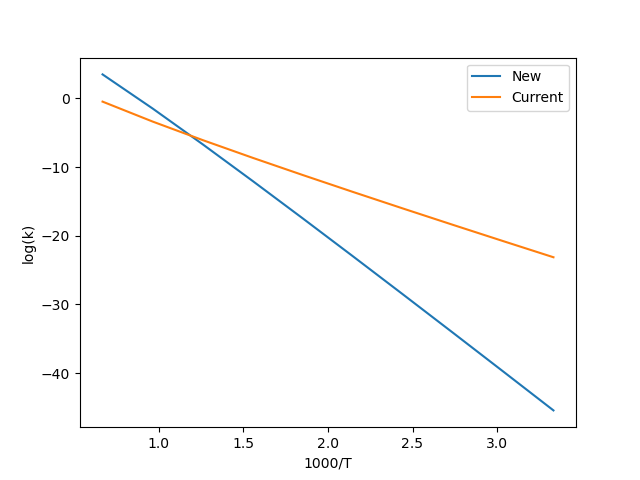


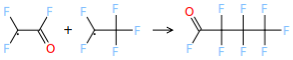
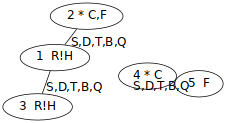
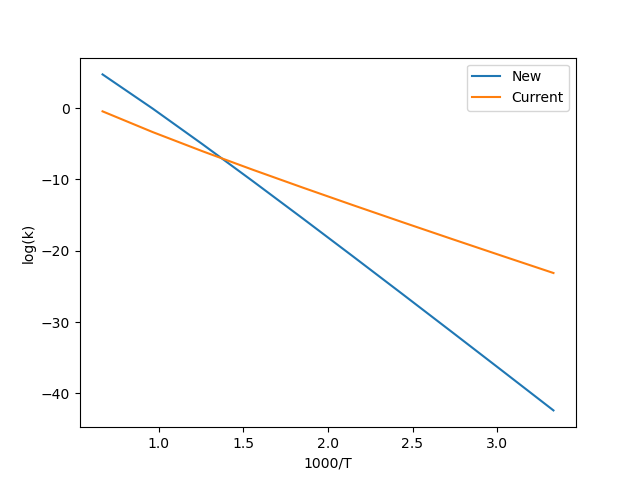


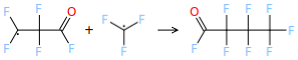
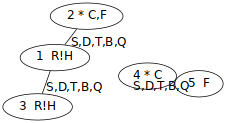
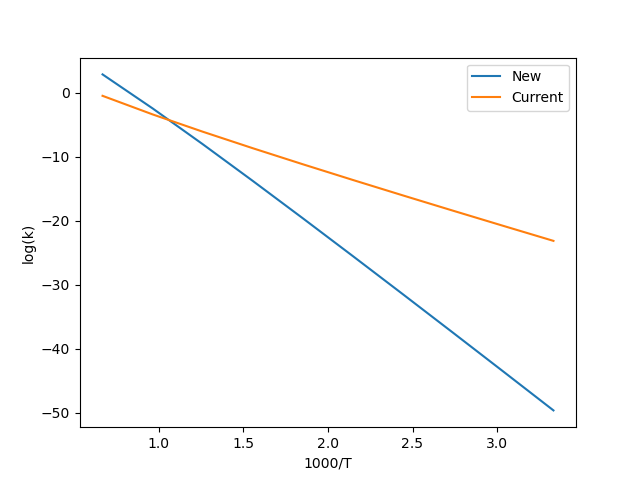


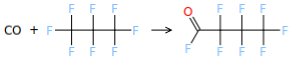
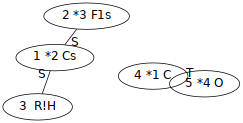
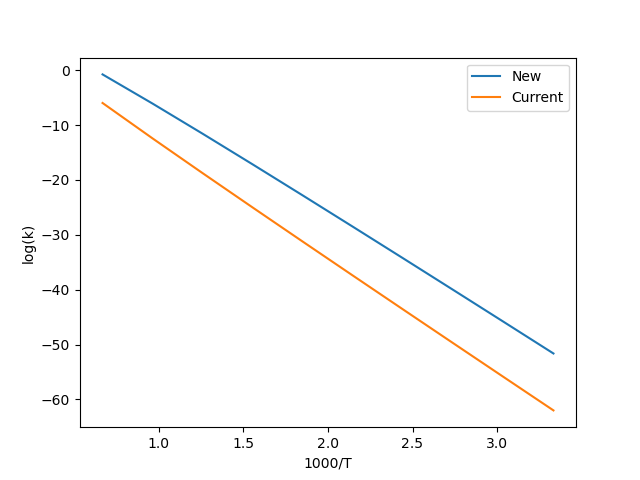


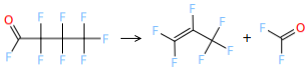


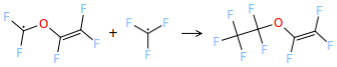
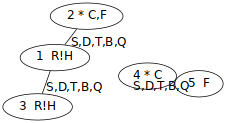
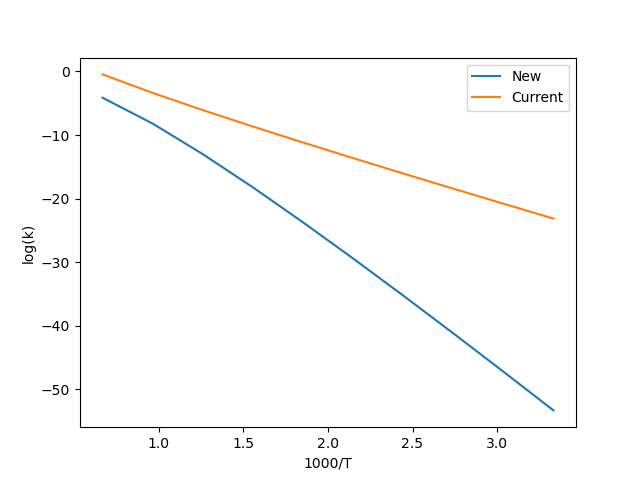


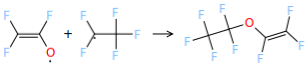
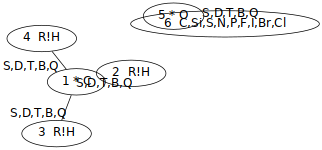
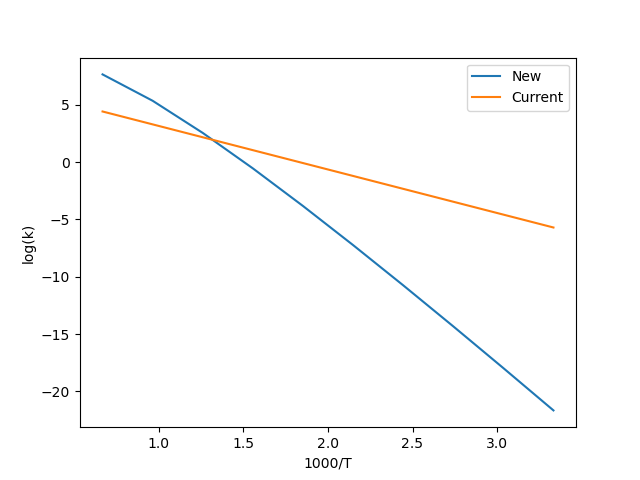


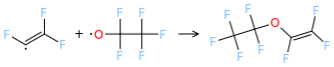
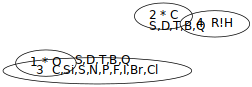
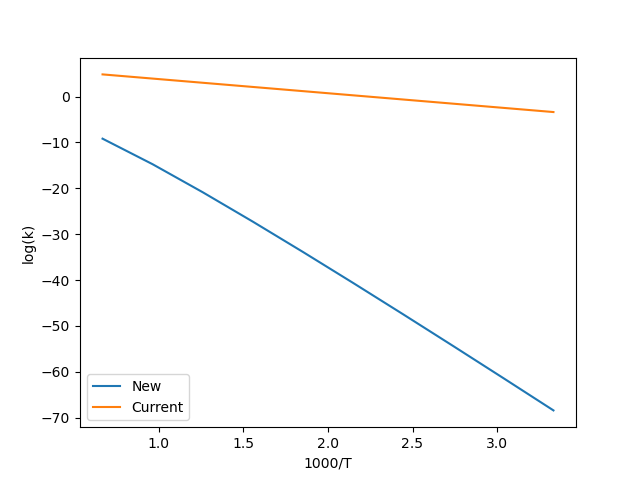


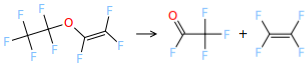


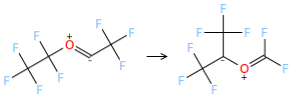
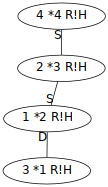
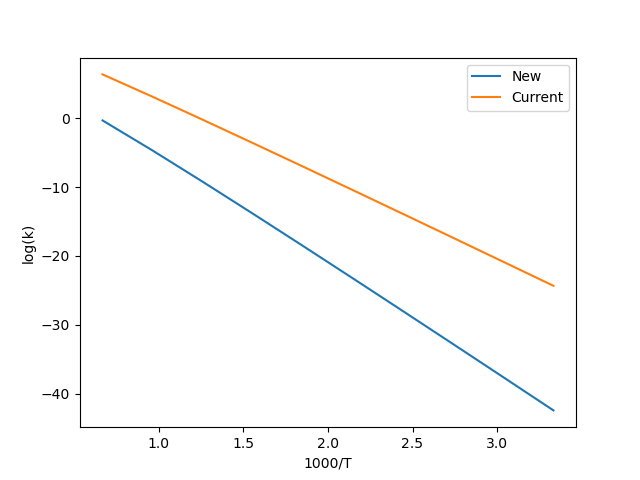


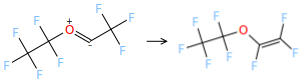


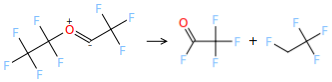


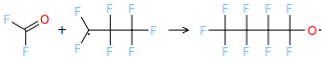
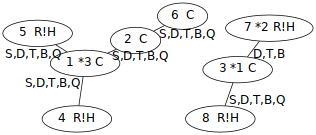
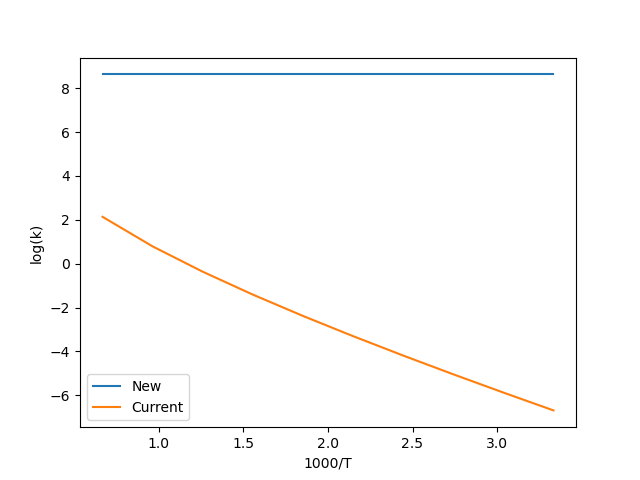


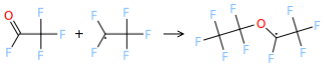
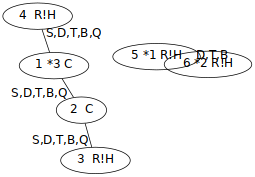
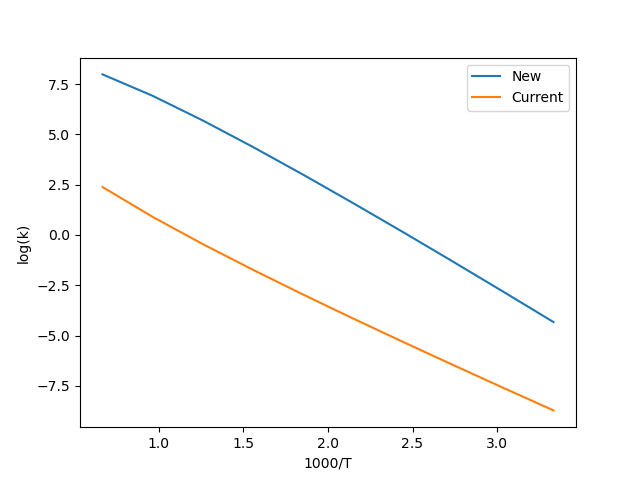


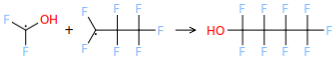
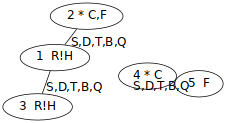
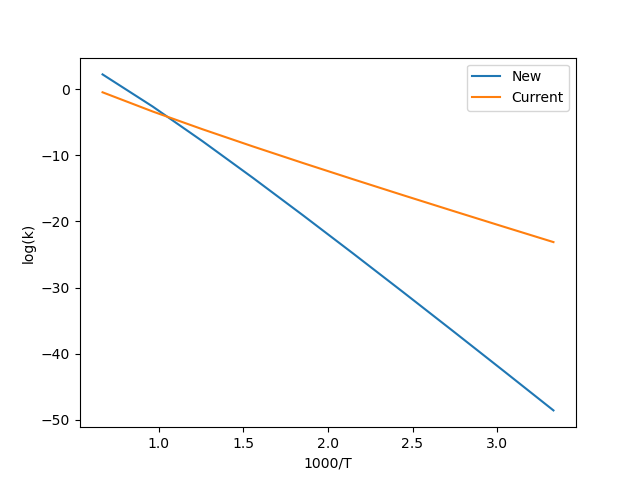


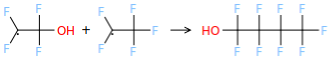
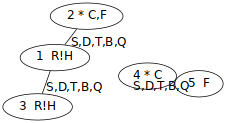
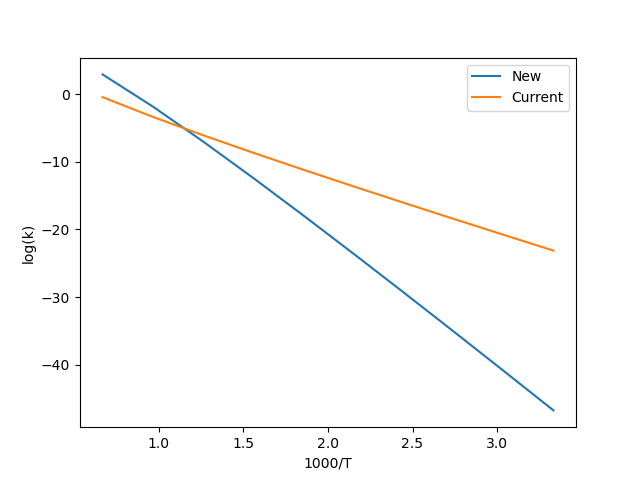


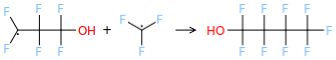
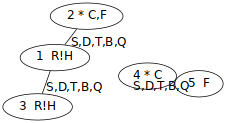
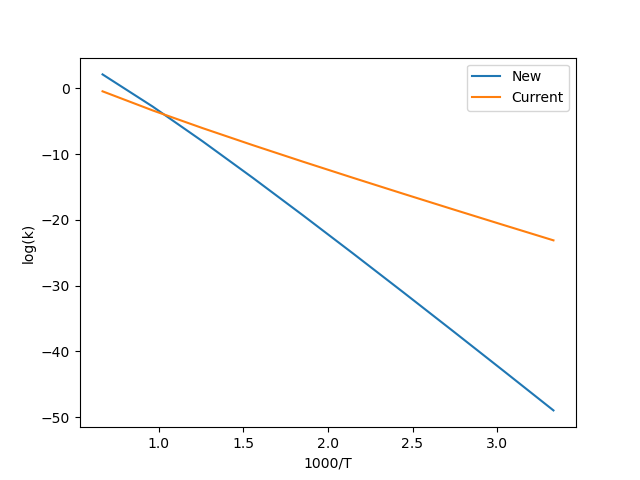


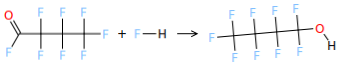
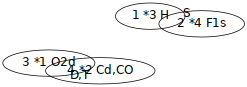
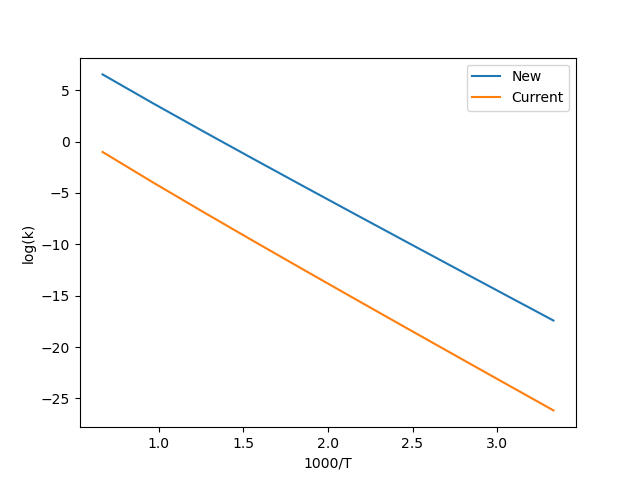


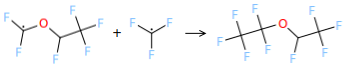
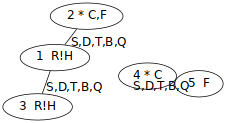
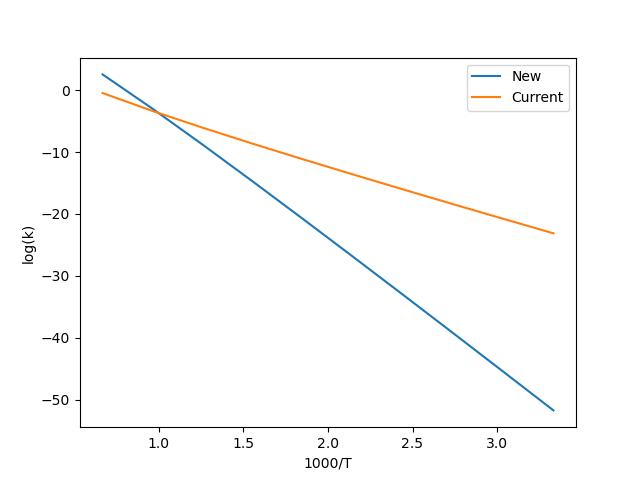


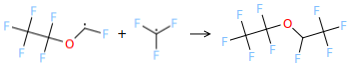
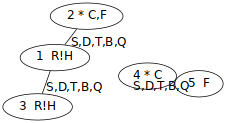
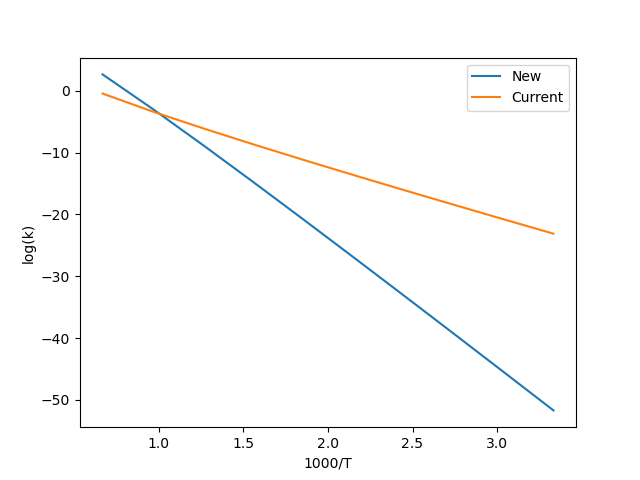


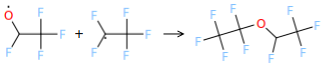
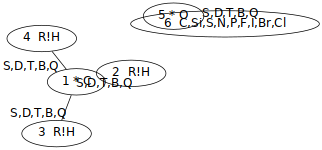
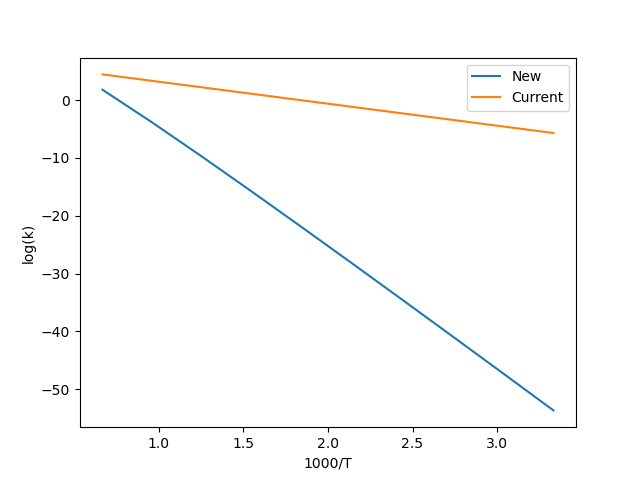


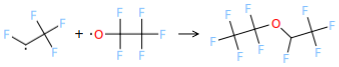
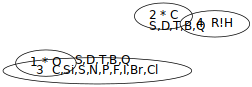
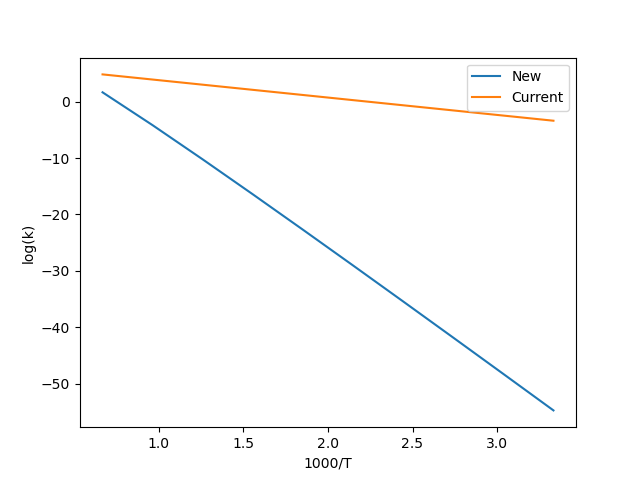


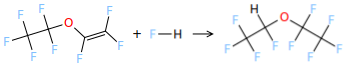
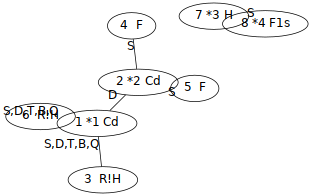
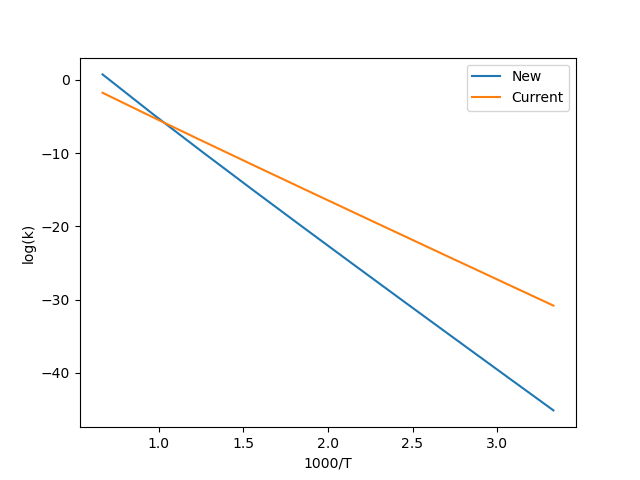


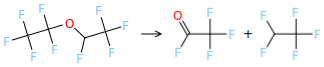


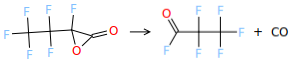


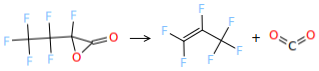


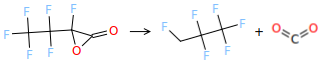


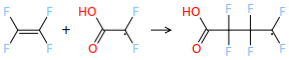
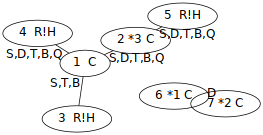
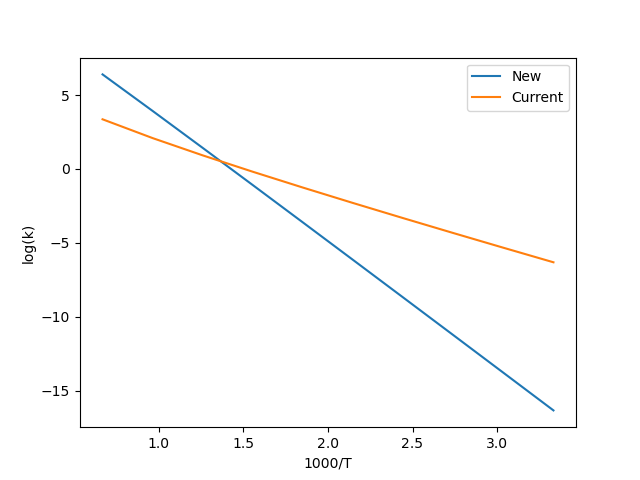


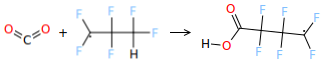
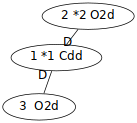
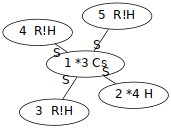
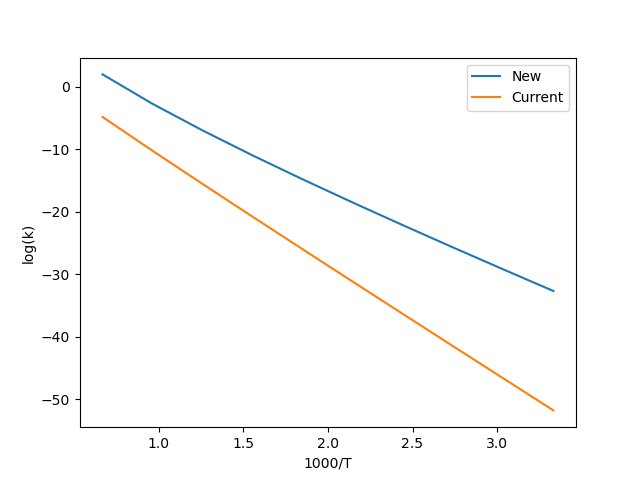


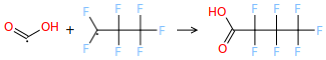
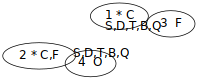
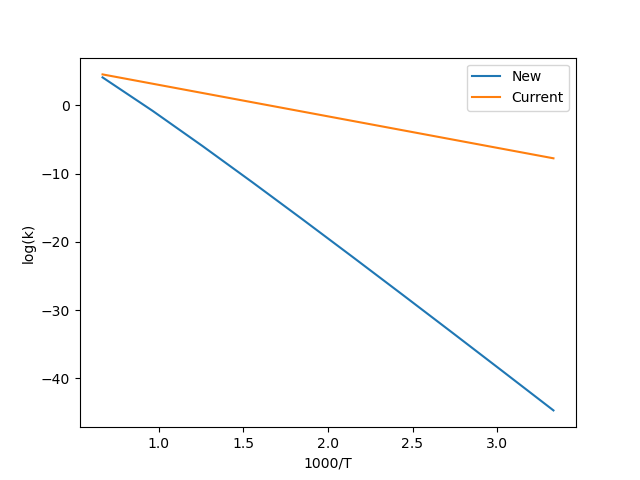


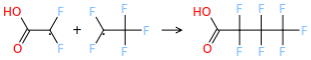
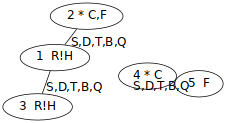
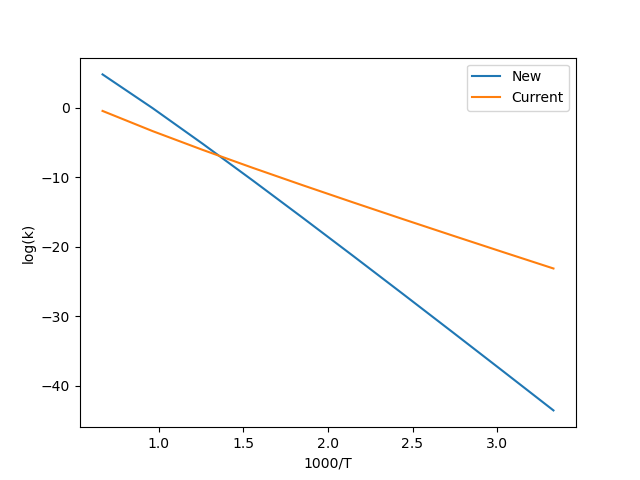


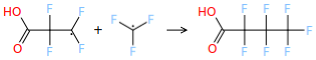
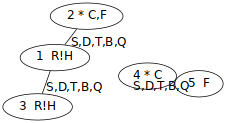
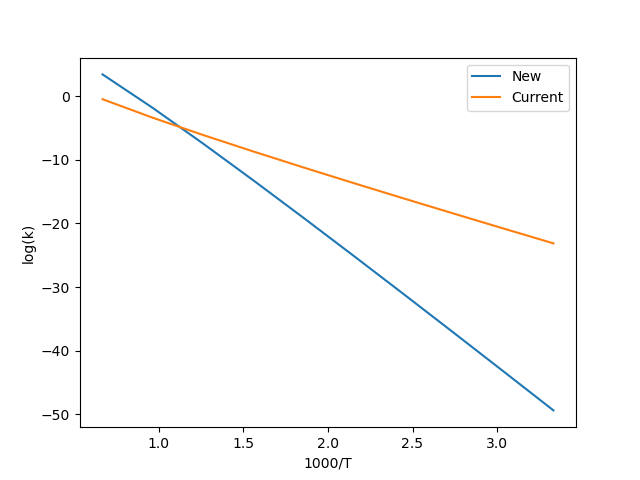


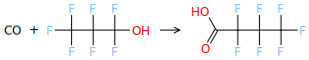
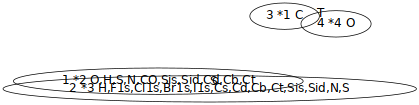
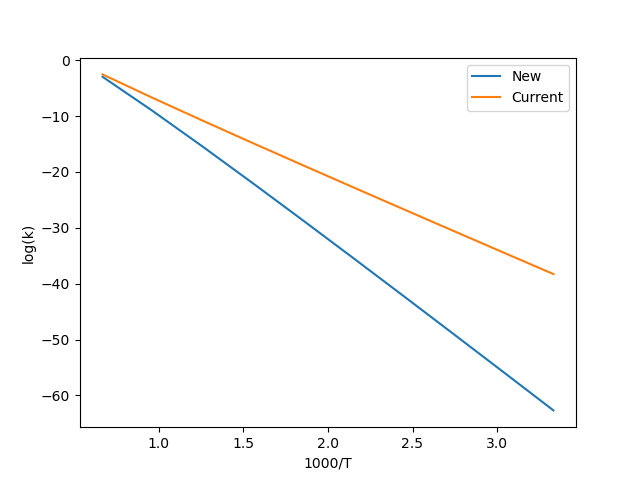


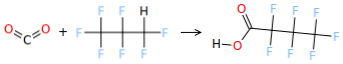
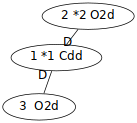
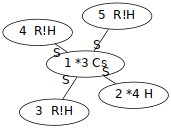
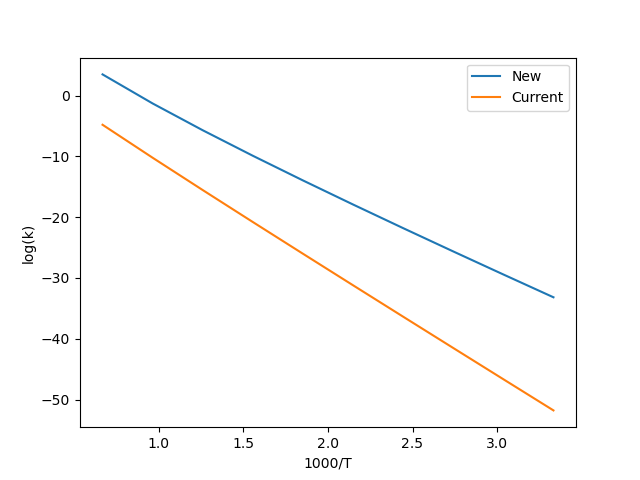


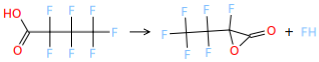


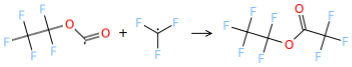
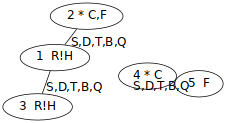
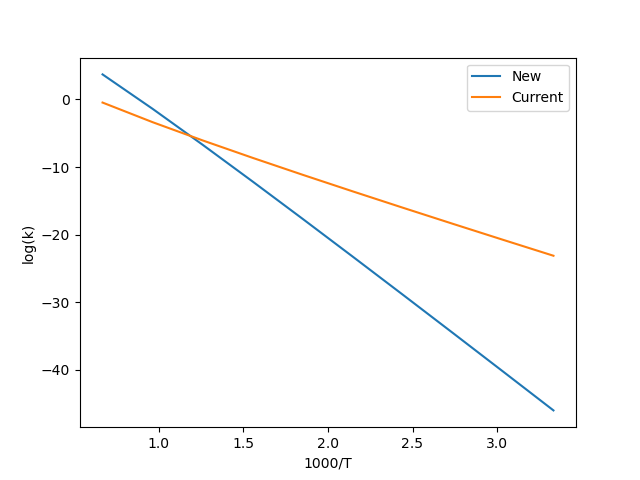


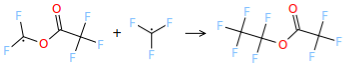
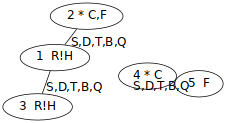
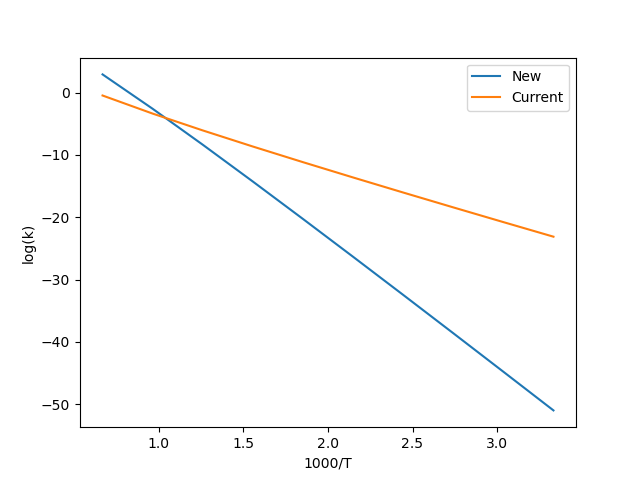


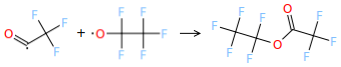
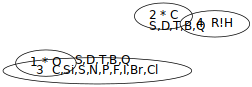
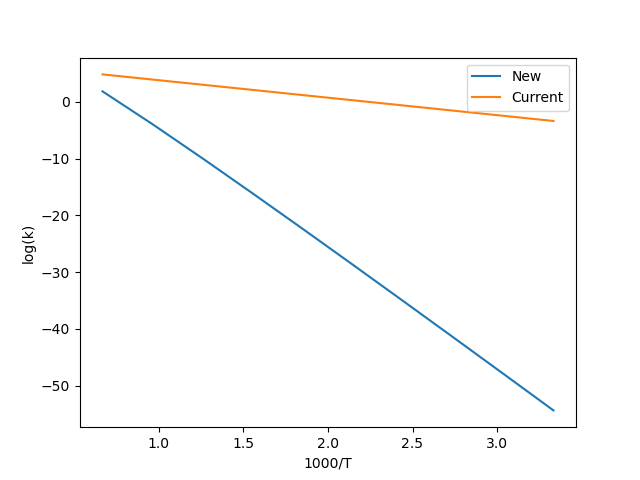


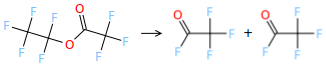


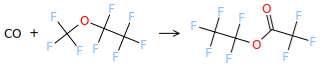
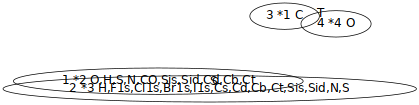
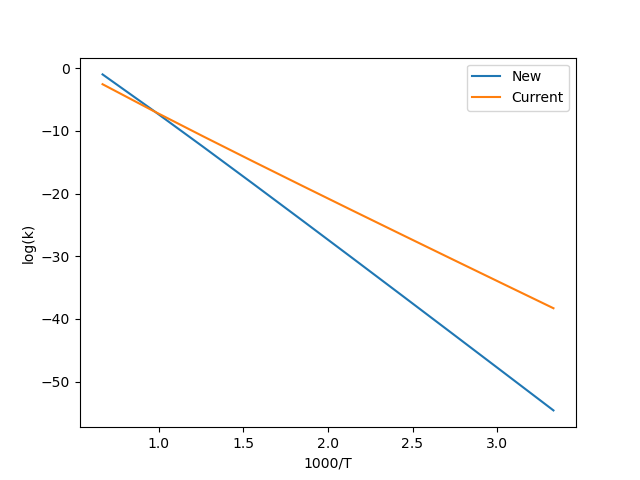


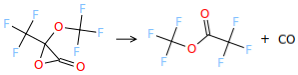


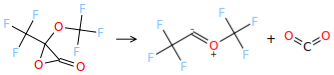


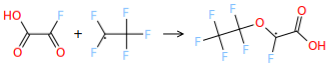
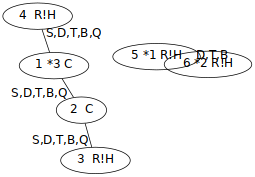
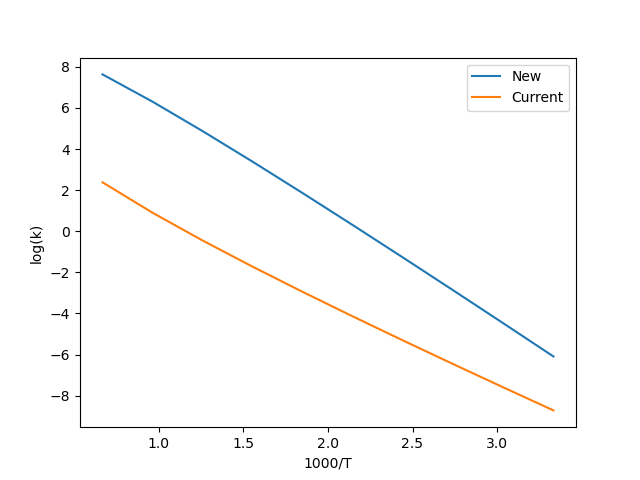


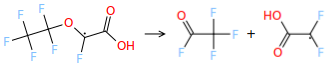


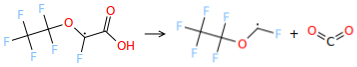


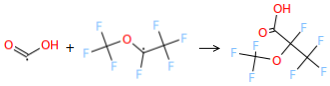
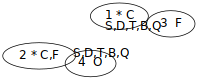
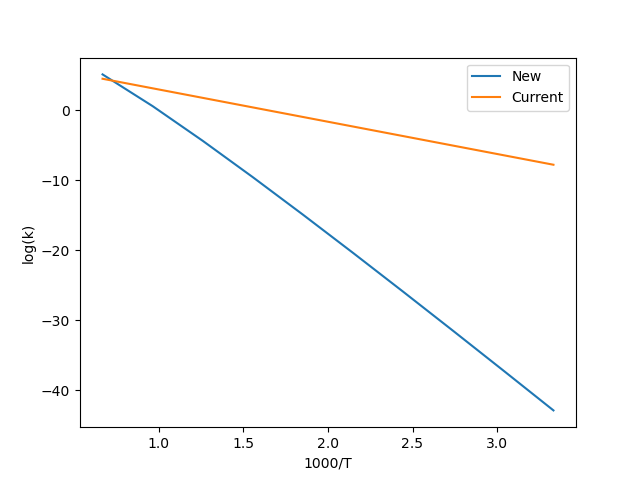


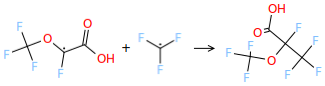
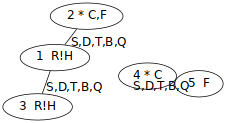
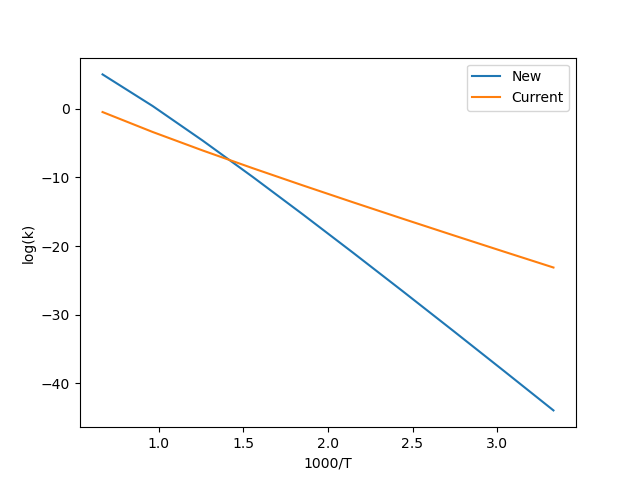


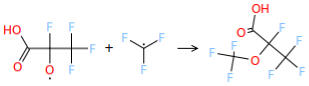
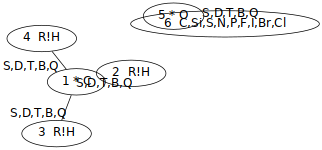
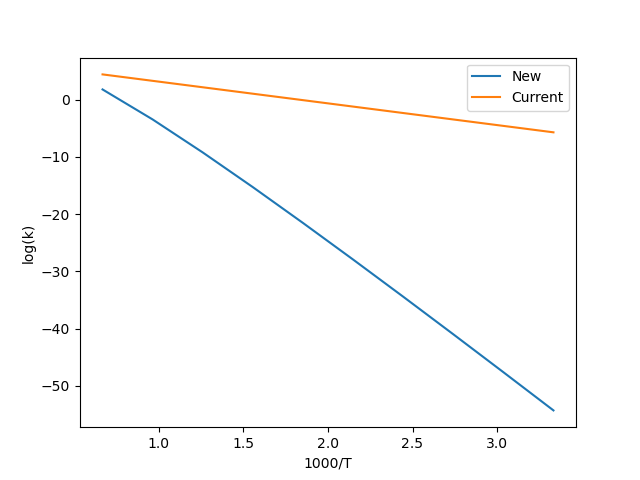


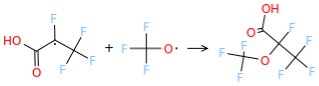
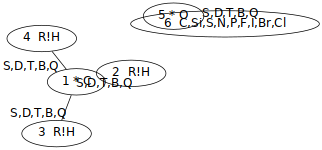
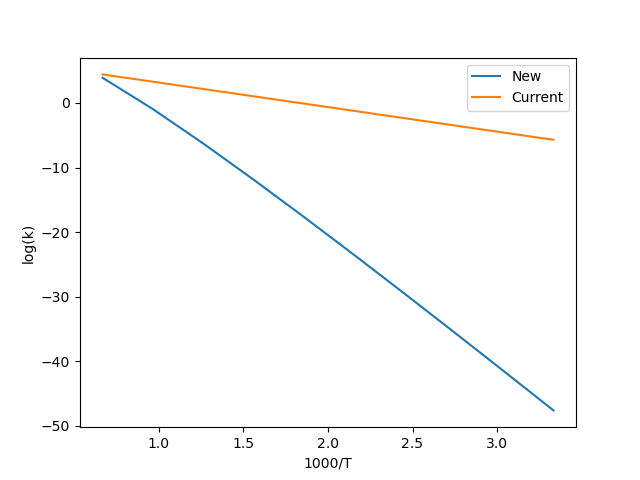


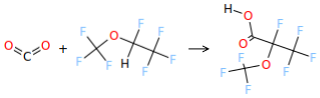
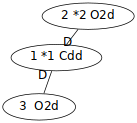
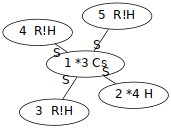
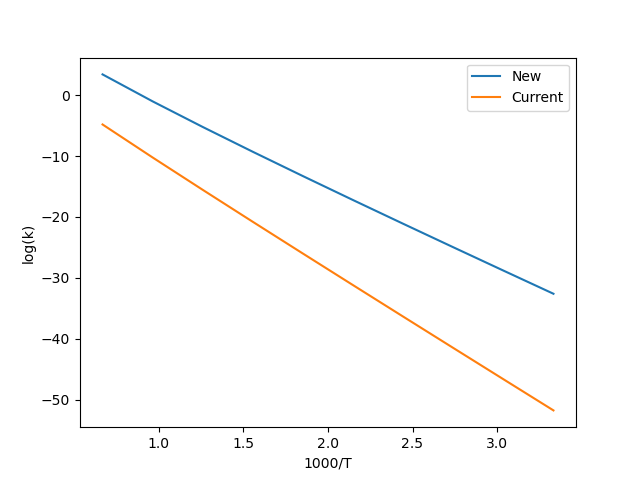


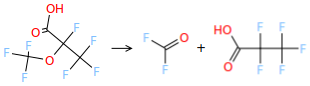


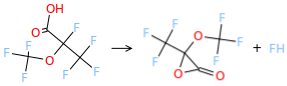


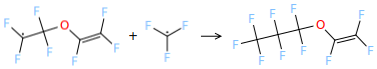
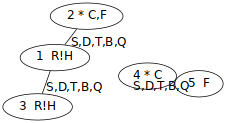
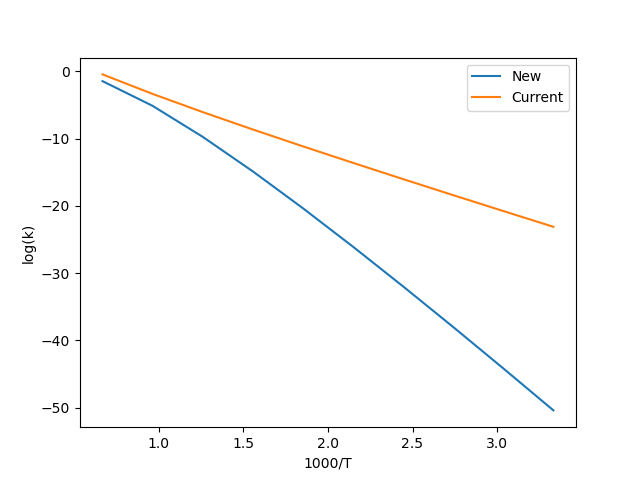


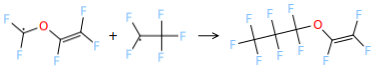
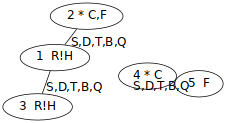
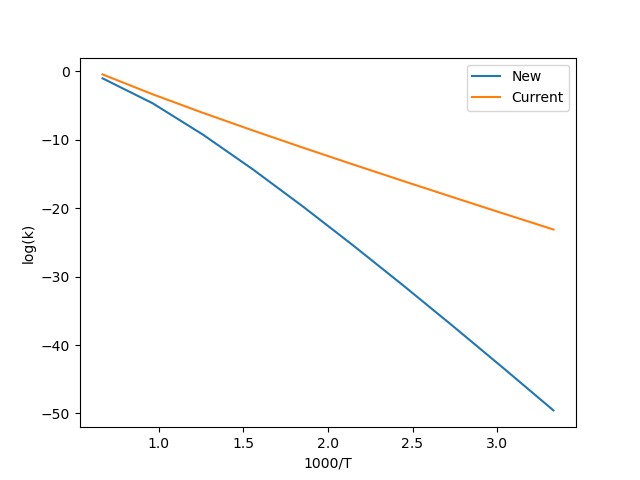


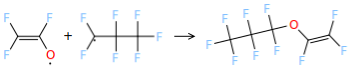
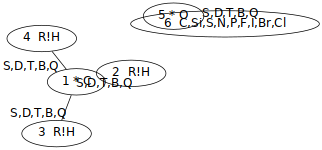
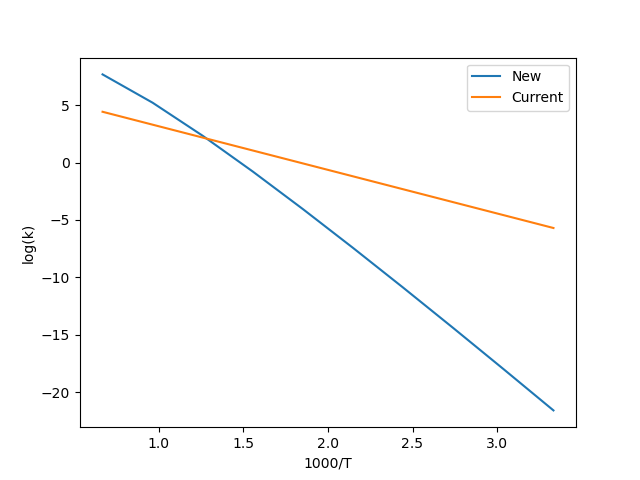


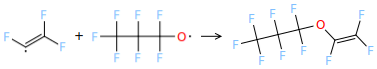
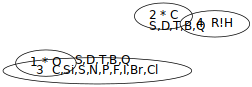
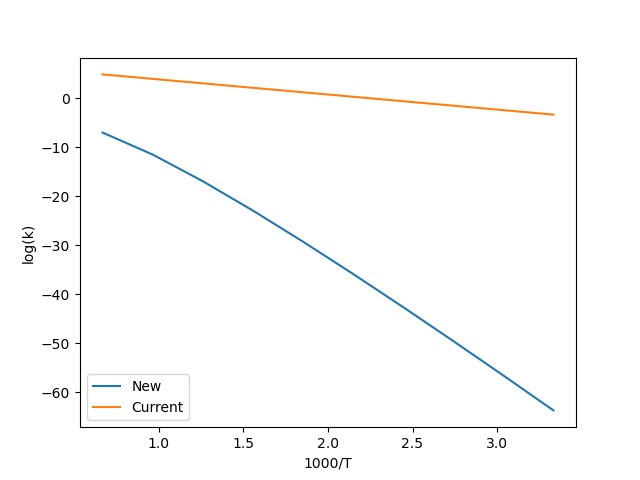


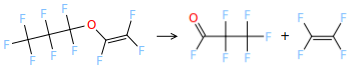


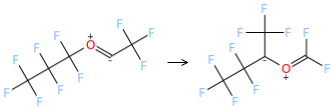
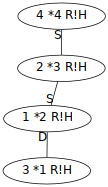
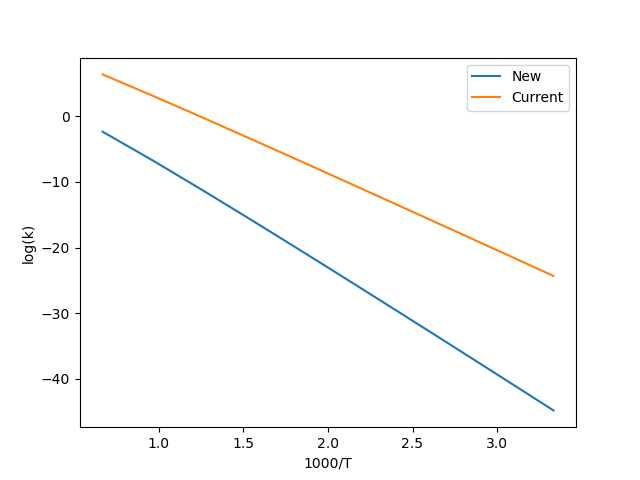


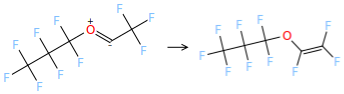


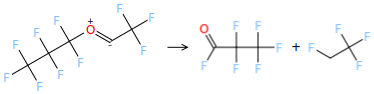


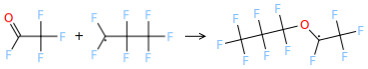
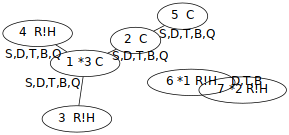
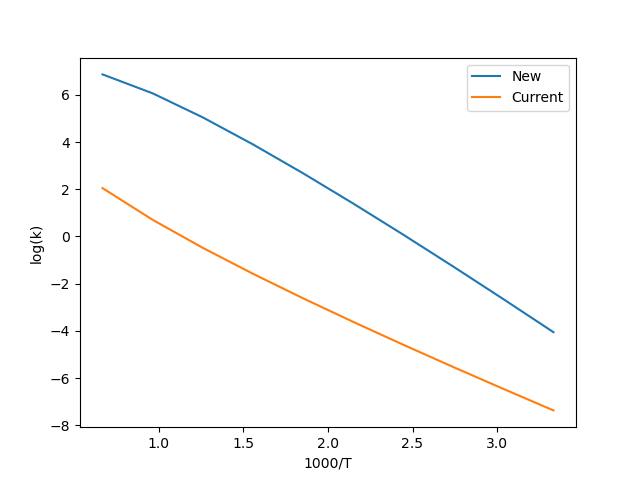


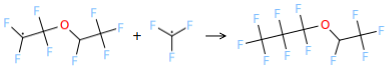
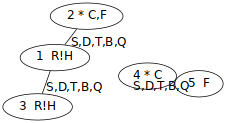
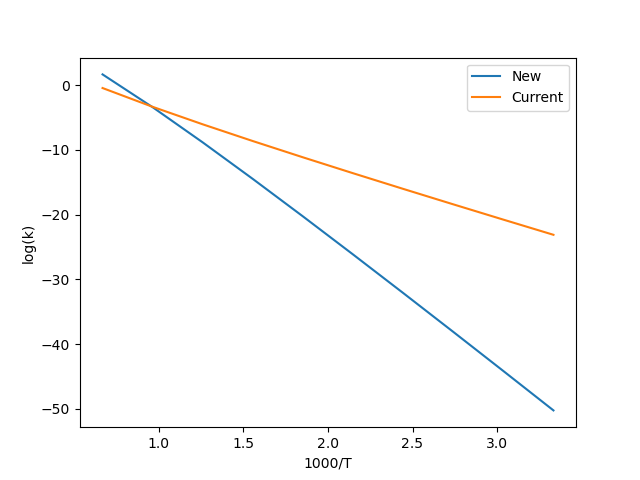


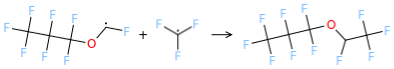
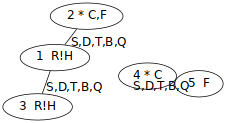
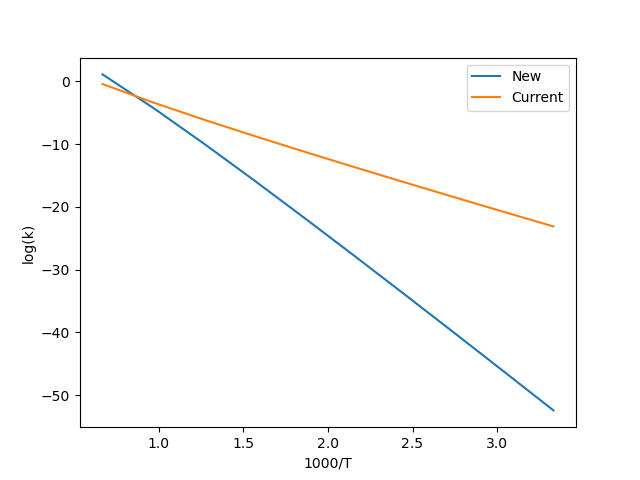


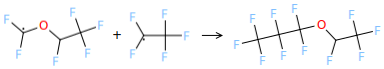
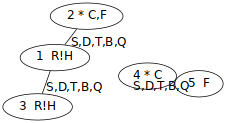
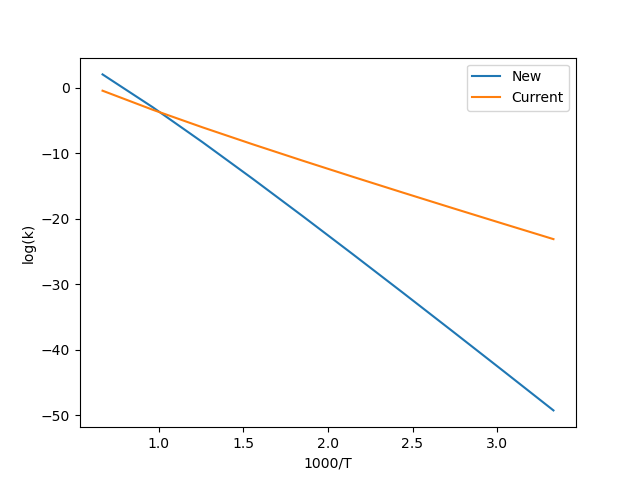


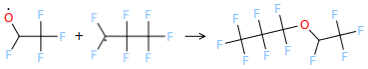
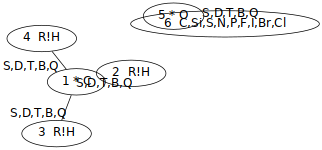
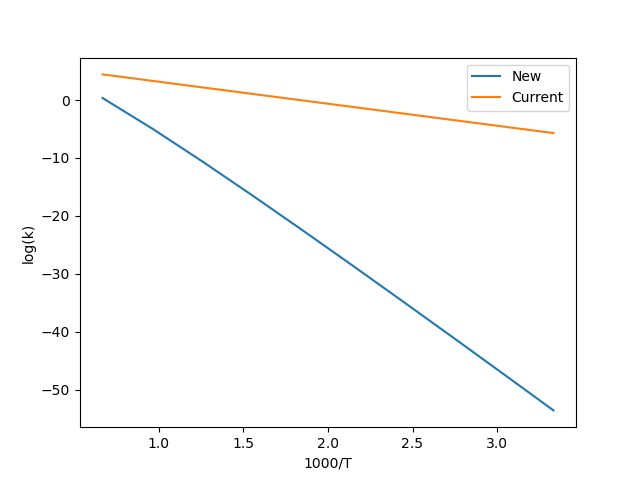


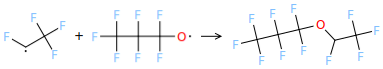
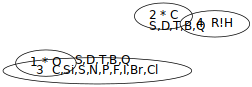
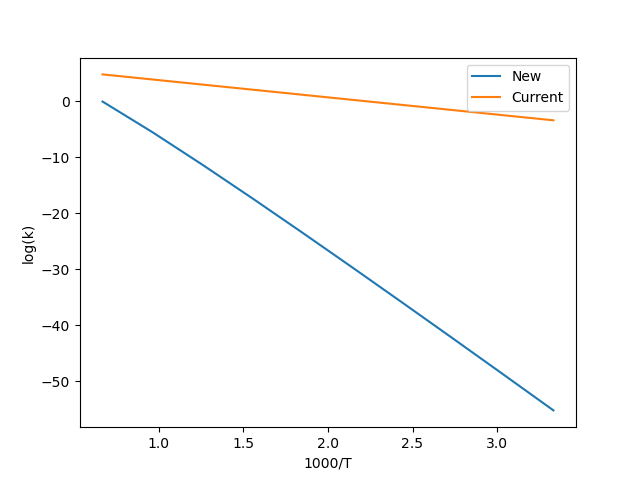


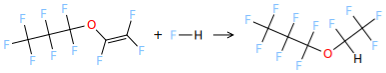
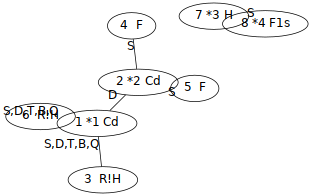
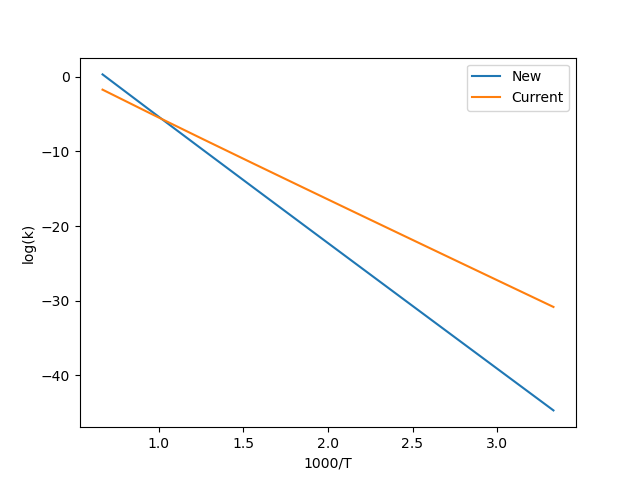


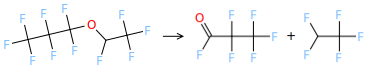


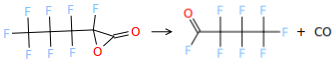


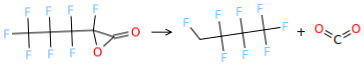


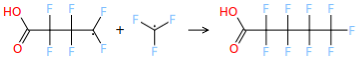
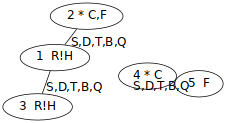
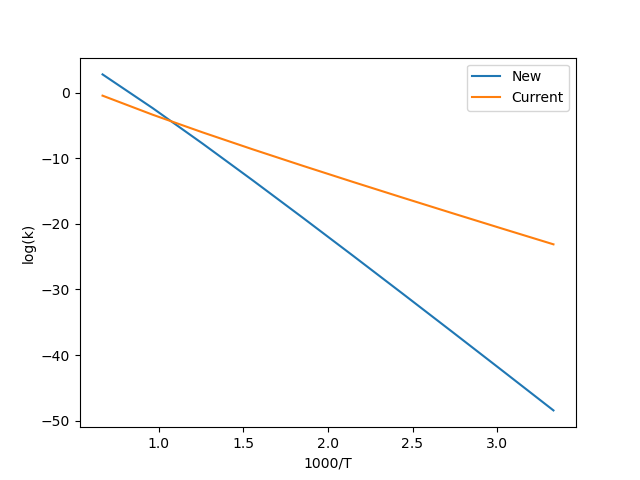


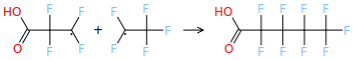
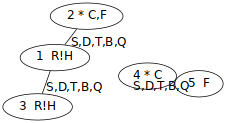
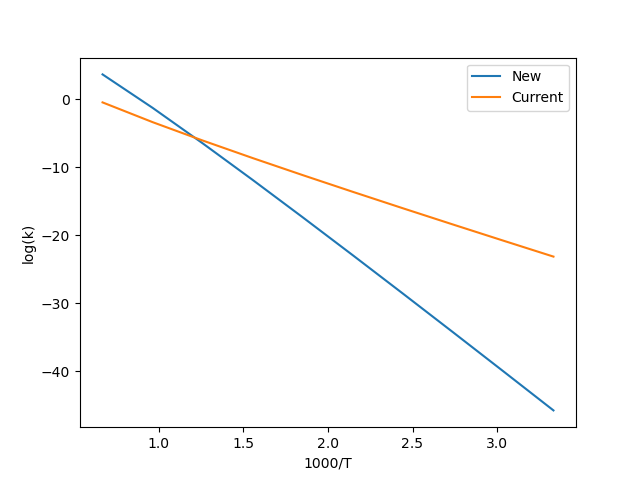


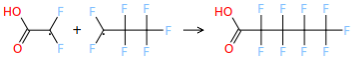
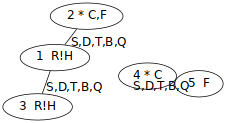
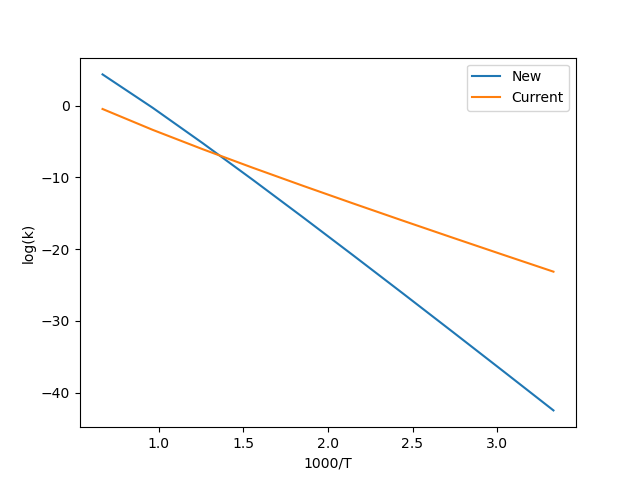


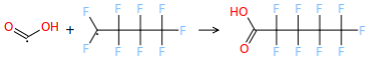
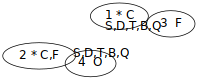
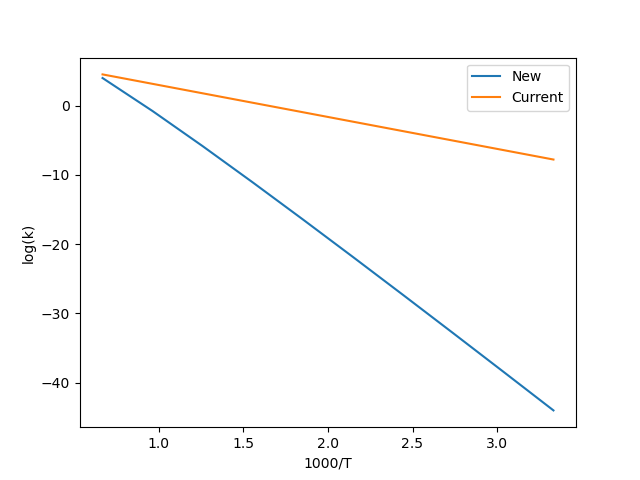


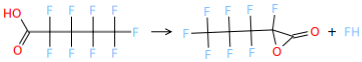


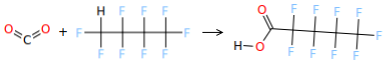
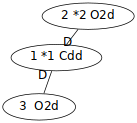
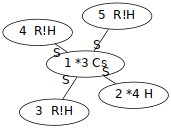
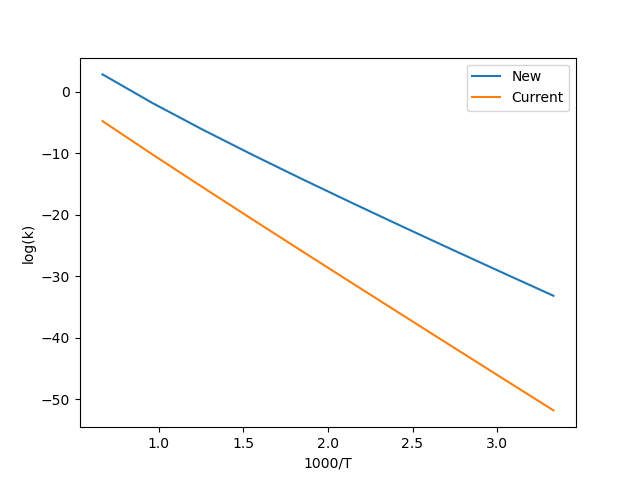


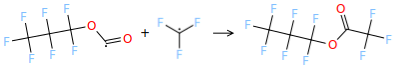
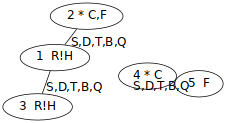
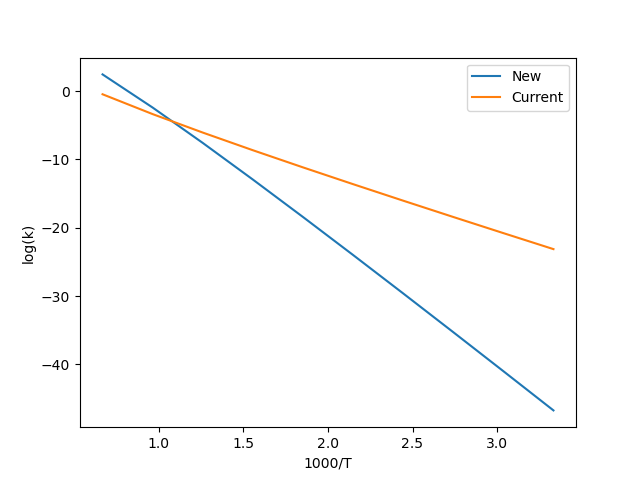


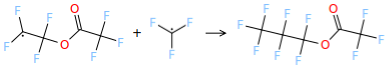
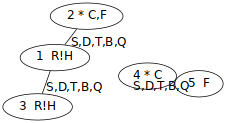
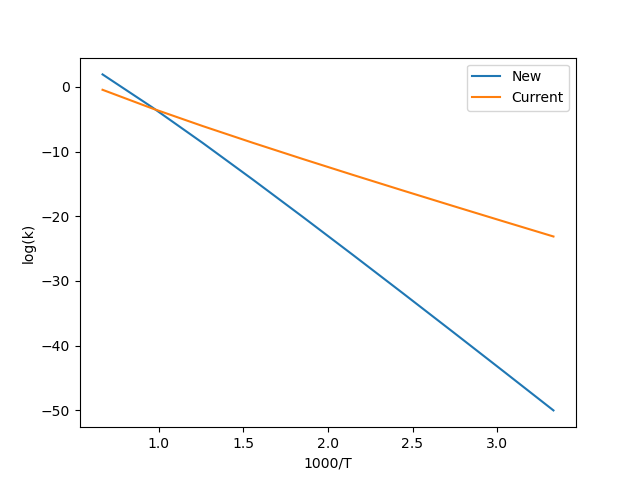


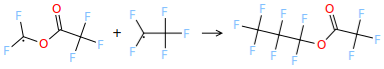
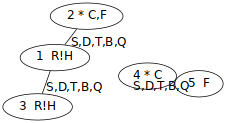
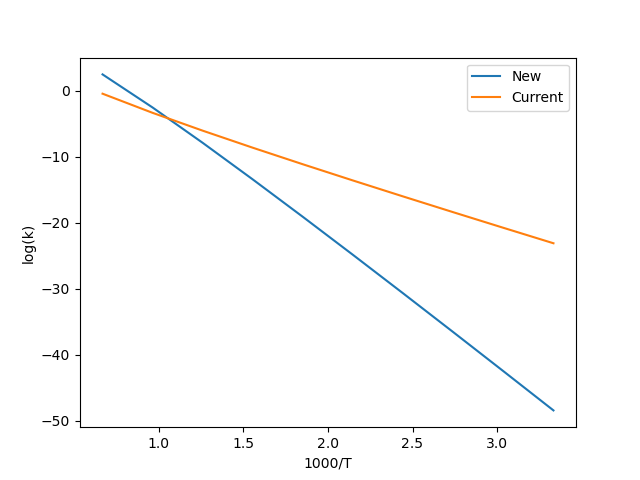


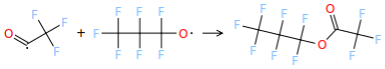
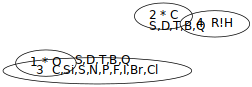
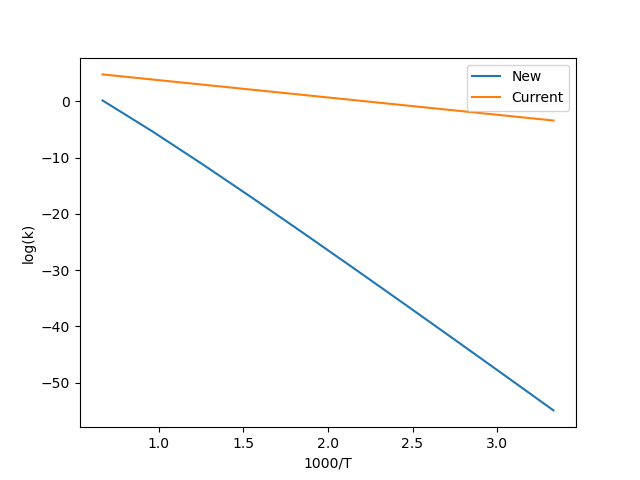


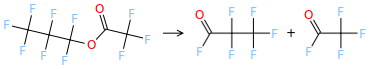


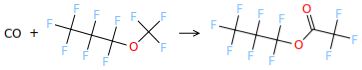
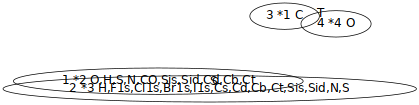
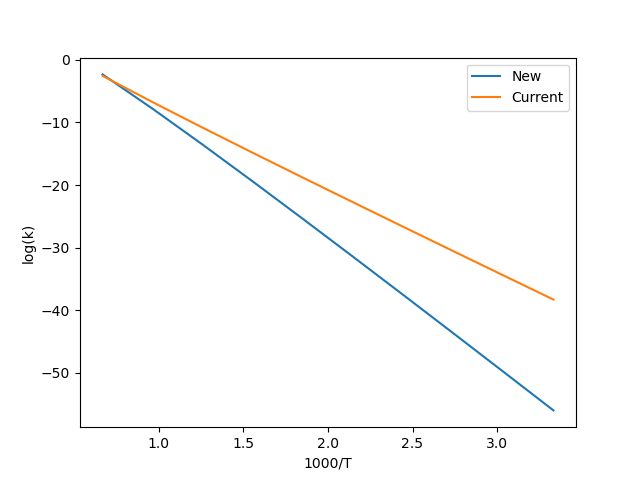


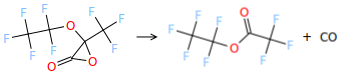


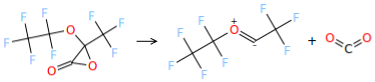


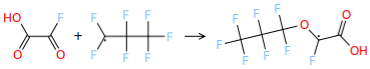
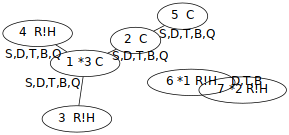
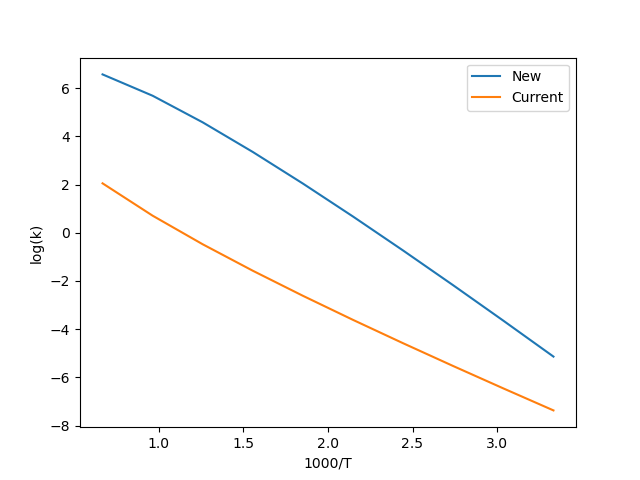


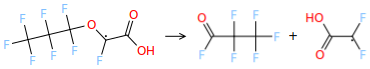


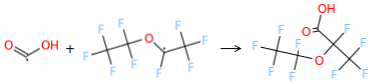
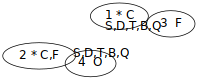
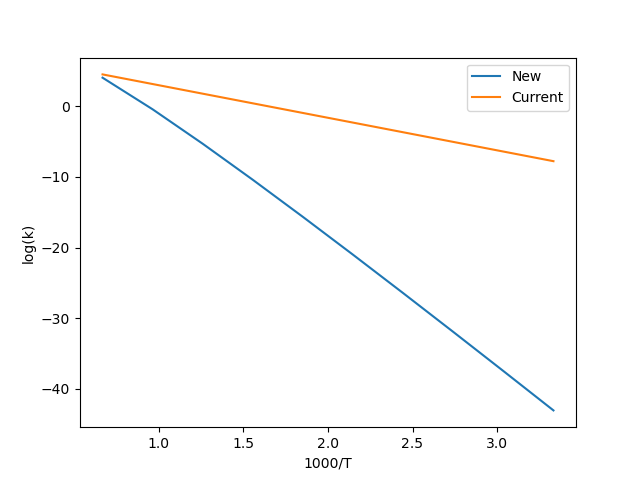


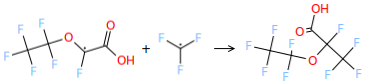
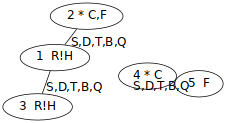
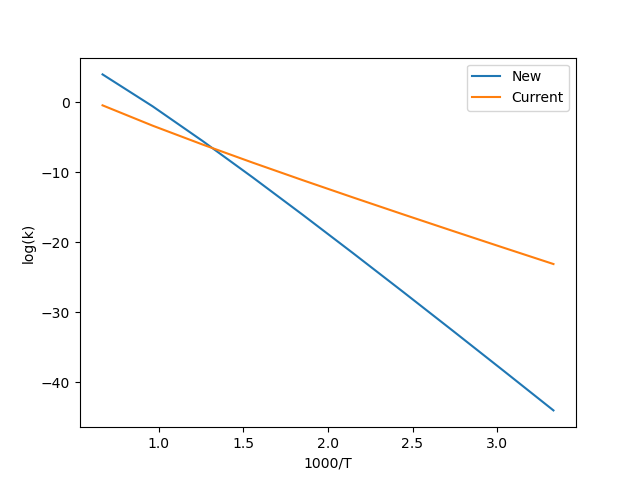


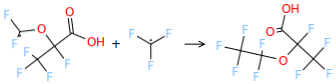
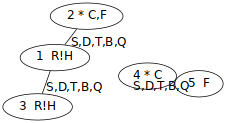
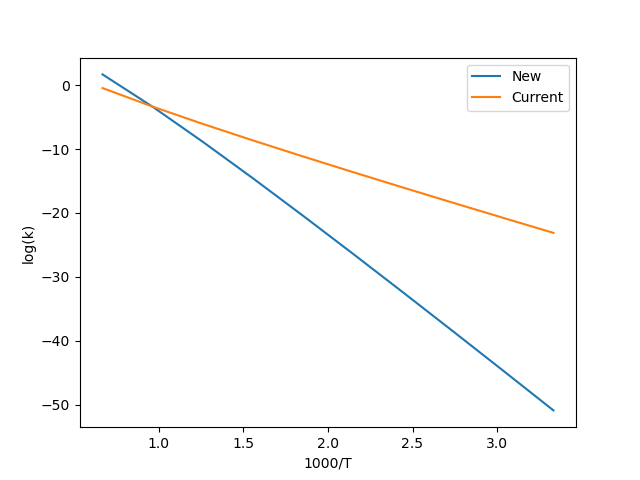


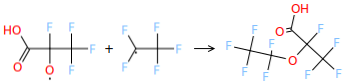
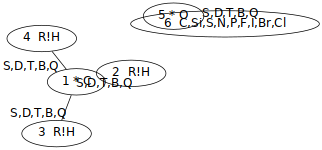
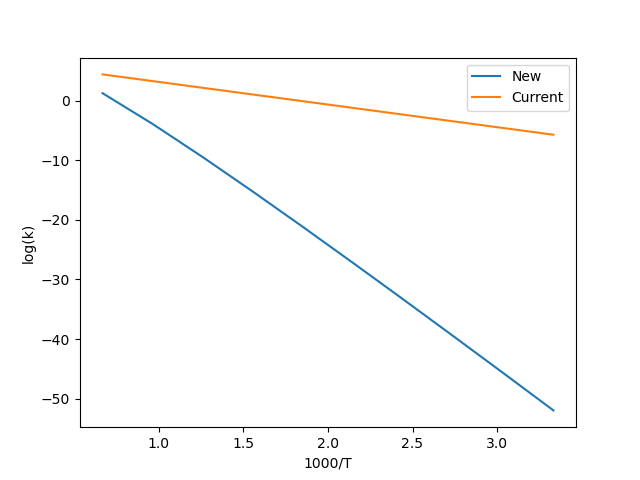


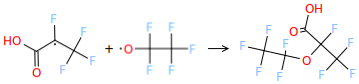
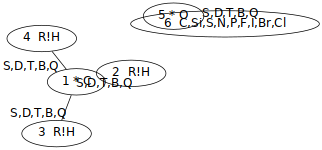
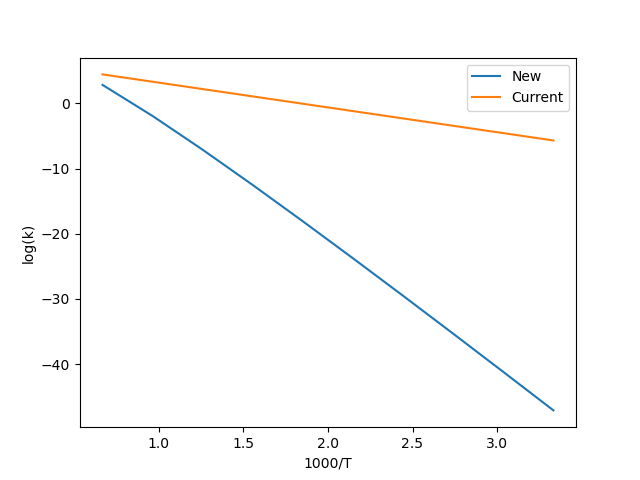


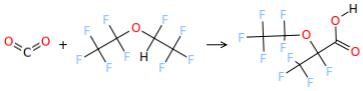
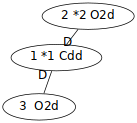
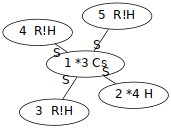
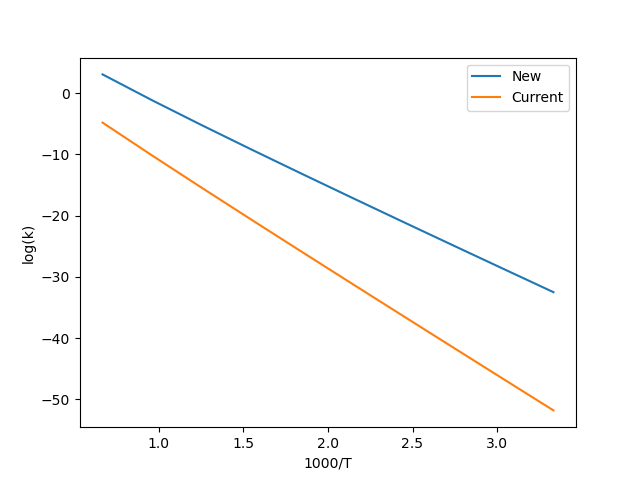


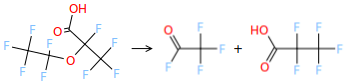


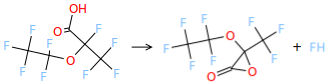


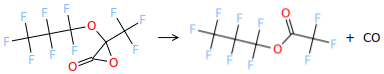


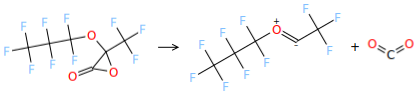


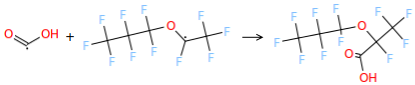
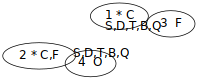
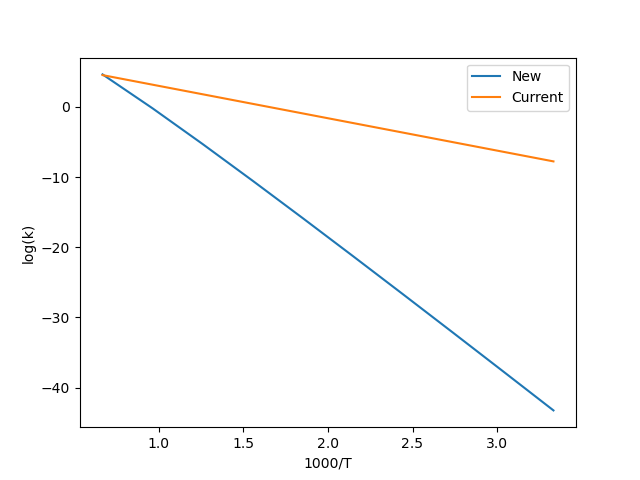


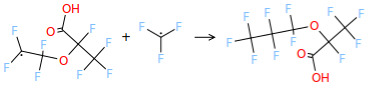
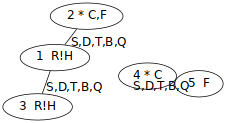
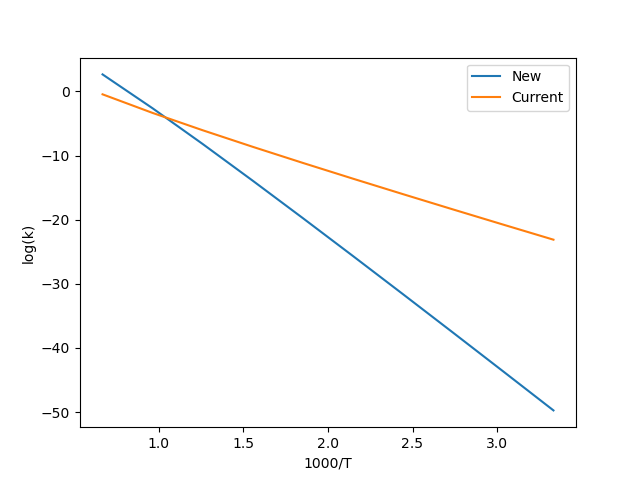


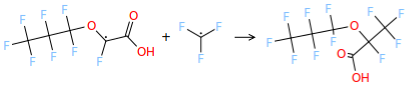
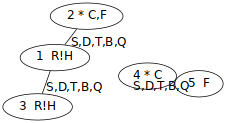
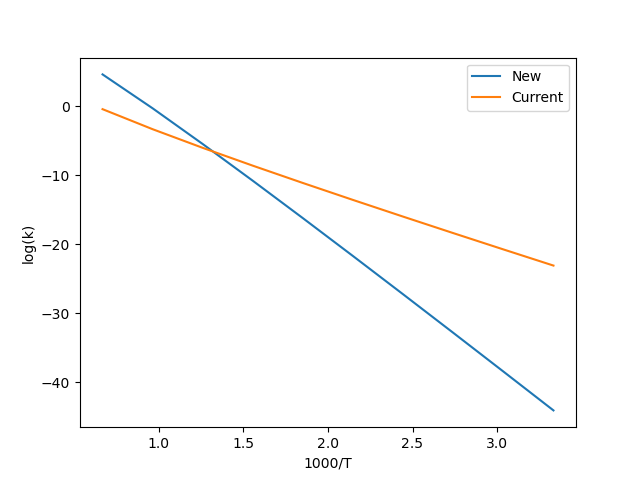


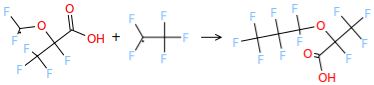
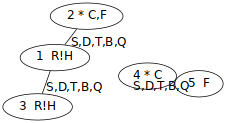
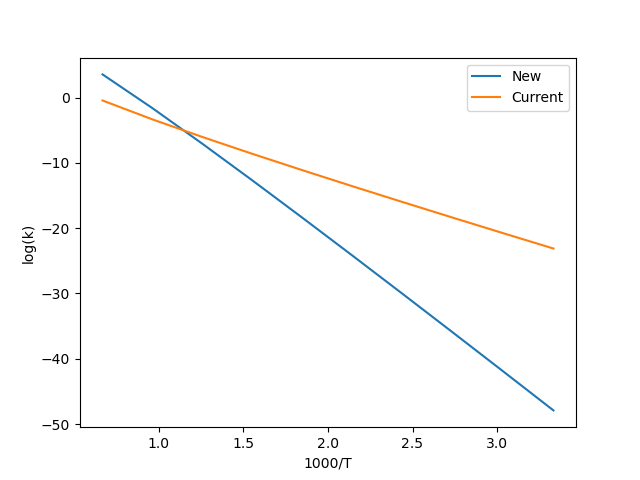


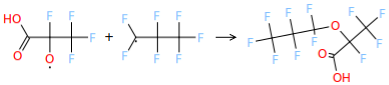
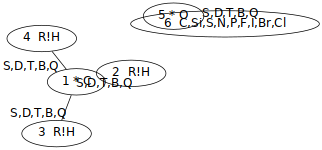
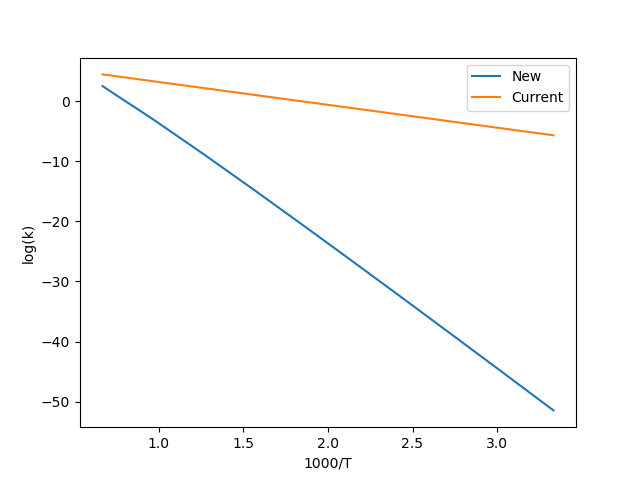


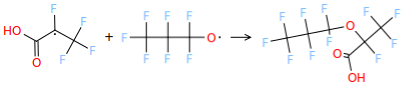
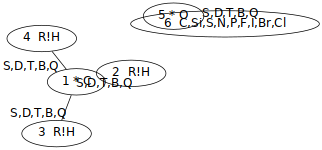
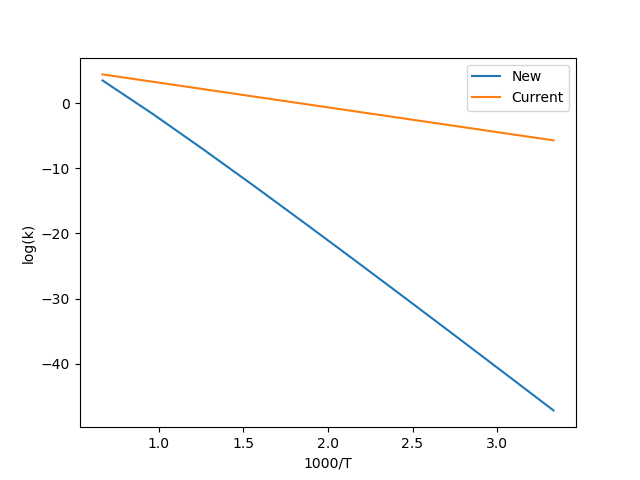


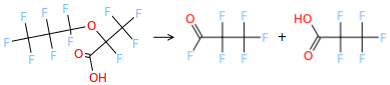


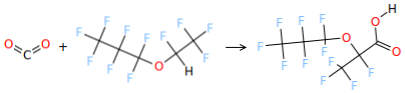
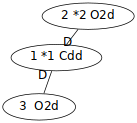
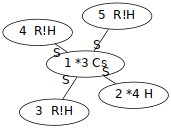
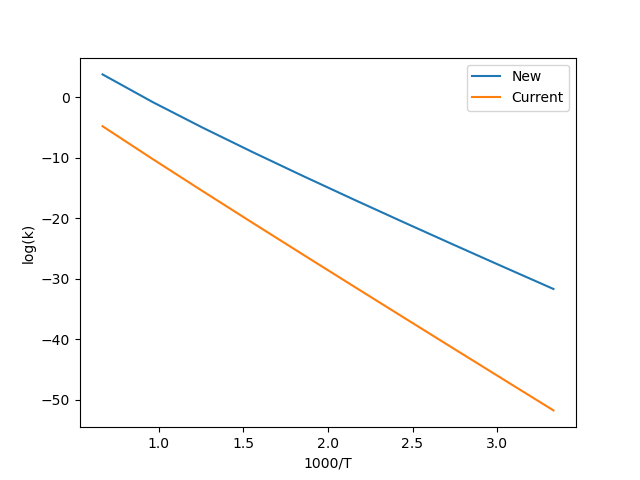


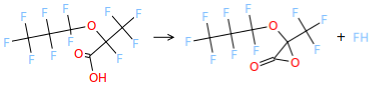


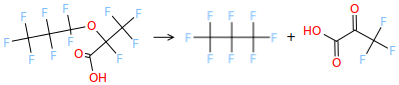


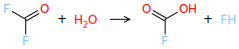


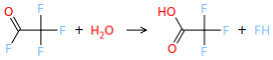


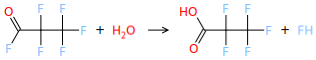


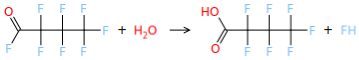

In [5]:
master_dict, multiple_dict, lib_fam_rxn_dict = process_reactions(database,
                                               libraries,
                                               list(database.kinetics.families.keys()),
                                               compare_kinetics=compare_kinetics,
                                               show_all=show_all,
                                               filter_aromatic=filter_aromatic)

In [7]:
reaction_dict = master_dict['PFAS_1atm_V1p0']



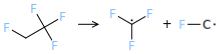
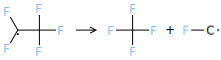
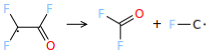
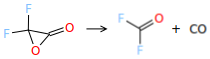
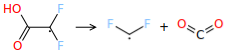
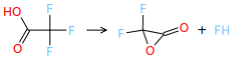
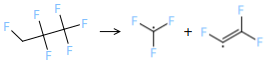
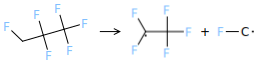
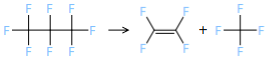
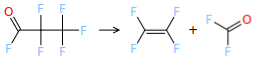
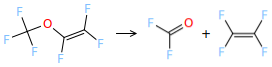
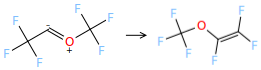
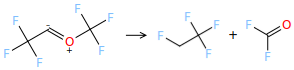
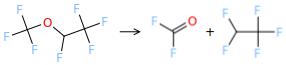
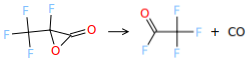
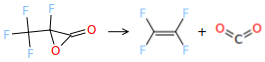
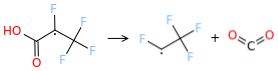
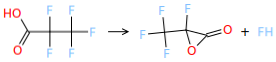
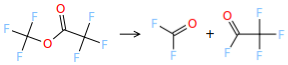
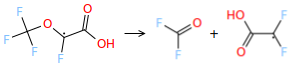
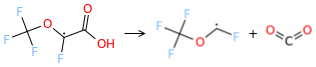
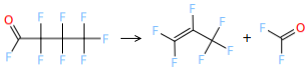
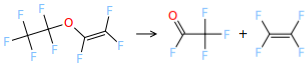
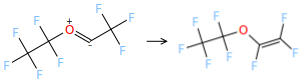
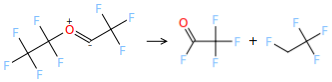
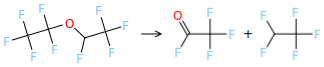
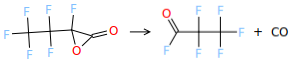
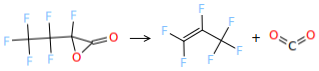
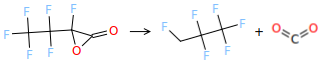
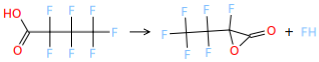
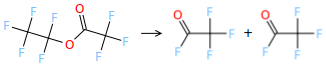
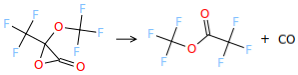
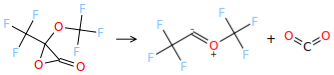
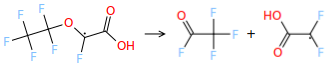
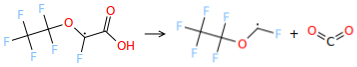
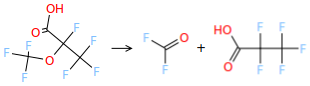
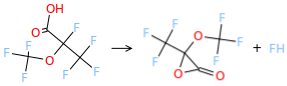
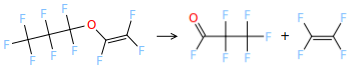
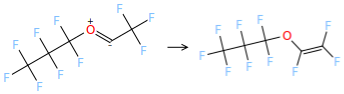
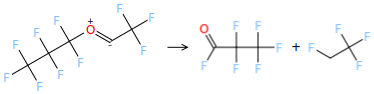
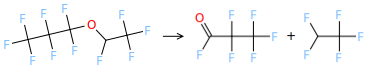
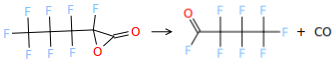
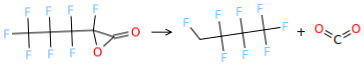
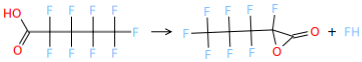
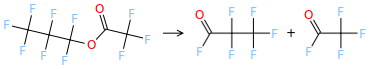
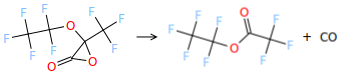
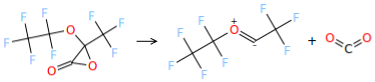
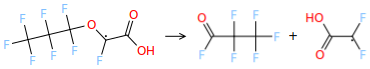
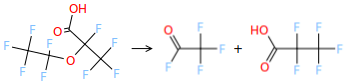
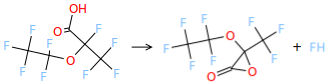
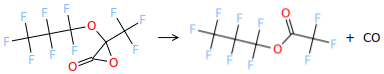
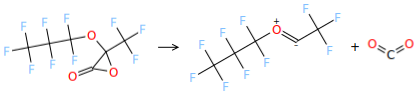
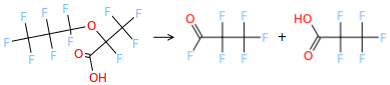
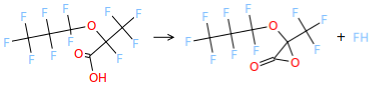
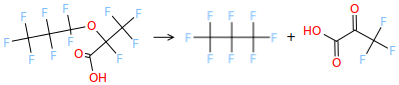
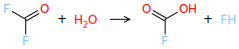
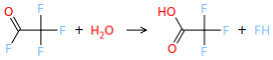
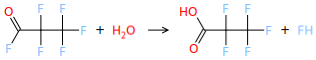
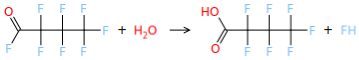

In [8]:
#these are the reactions that were unmatched
pick_out_unmatched_rxns(database, libraries, list(database.kinetics.families.keys()))

In [ ]:
reaction_dict.keys()
#these are the reaction families that were matched 
#['R_Recombination', '1,2_Insertion_carbene', 'R_Addition_MultipleBond', 'XY_Addition_MultipleBond', 'Singlet_Carbene_Intra_Disproportionation', '1,2_Insertion_CO', '1+2_Cycloaddition', '1,3_Insertion_CO2', '1,3_sigmatropic_rearrangement']

In [ ]:
family_name = 'R_Recombination'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)



In [ ]:
family_name = '1,2_Insertion_carbene'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)


In [ ]:
family_name = 'R_Addition_MultipleBond'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)


In [ ]:
family_name = 'XY_Addition_MultipleBond'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)


In [ ]:
family_name = 'Singlet_Carbene_Intra_Disproportionation'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)


In [ ]:
family_name = '1,2_Insertion_CO'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)


In [ ]:
family_name = '1+2_Cycloaddition'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)


In [ ]:
family_name = '1,3_Insertion_CO2'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)


In [ ]:
family_name = '1,3_sigmatropic_rearrangement'
analyze_per_family(family_name, lib_fam_rxn_dict, reaction_dict, database, compare_kinetics=True)


In [ ]:
#find the reactions without matches and save them to a file


## Step 2b (optional): Review and select reactions to be added

In [ ]:
review_reactions(master_dict, prompt=True)

## Step 2c (optional): Manual processing for reactions with multiple matches

In [ ]:
manual_selection(master_dict, multiple_dict, database)

## Step 2d: Final review of reactions to be added

In [ ]:
review_reactions(master_dict, prompt=False)

## Step 3: Write the new training reactions to the database

In [ ]:
for library_name, reaction_dict in master_dict.items():
    library = database.kinetics.libraries[library_name]
    
    for family_name, reaction_list in reaction_dict.items():
        print('Adding training reactions from {0} to {1}...'.format(library_name, family_name))

        family = database.kinetics.families[family_name]
        try:
            depository = family.get_training_depository()
        except:
            raise Exception('Unable to find training depository in {0}. Check that one exists.'.format(family_name))

        print('Training depository previously had {} rxns. Now adding {} new rxn(s).'.format(len(depository.entries), len(reaction_list)))

        ref_list = []
        type_list = []
        short_list = []
        long_list = []
        
        for reaction in reaction_list:
            # Get the original entry to retrieve metadata
            orig_entry = library.entries[reaction.index]
            short_desc = orig_entry.short_desc
            long_desc = 'Training reaction from kinetics library: {0}\nOriginal entry: {1}'.format(library_name, orig_entry.label)
            if orig_entry.long_desc:
                long_desc += '\n' + orig_entry.long_desc
            
            ref_list.append(orig_entry.reference)
            type_list.append(orig_entry.reference_type)
            short_list.append(short_desc)
            long_list.append(long_desc)
            
        family.save_training_reactions(
            reaction_list,
            reference=ref_list,
            reference_type=type_list,
            short_desc=short_list,
            long_desc=long_list,
        )